In [1]:
import nibabel as nib
import numpy as np
import os 
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

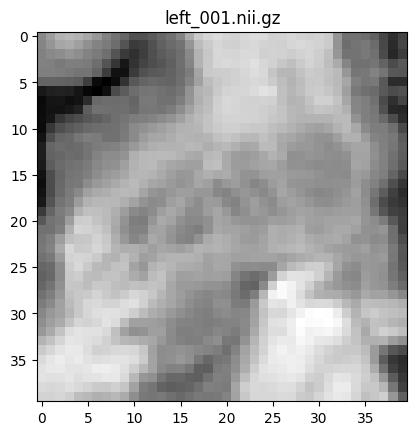

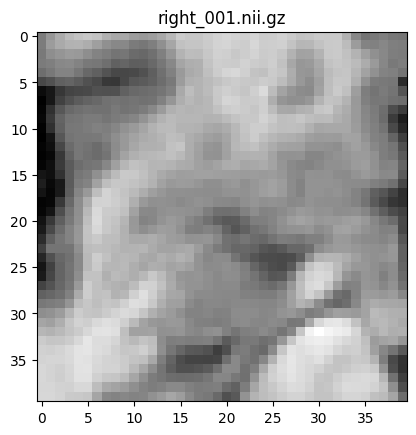

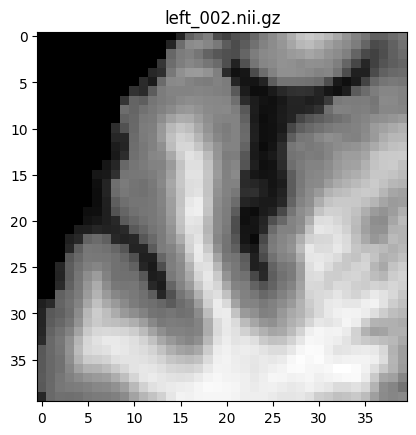

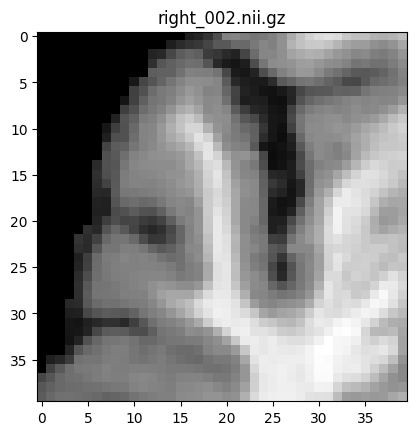

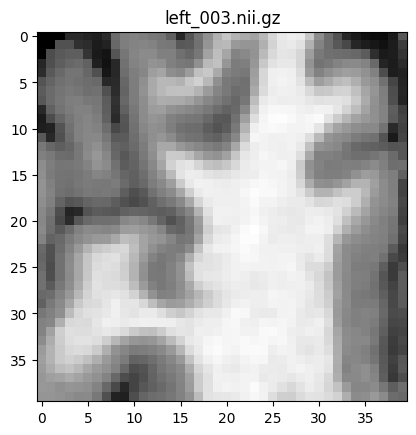

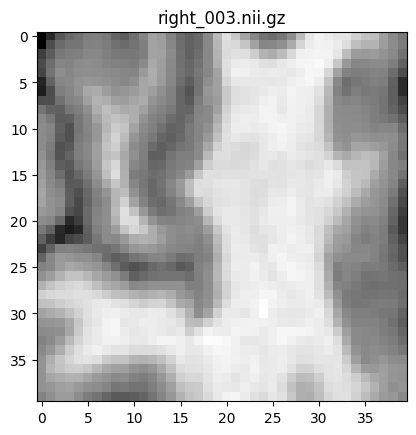

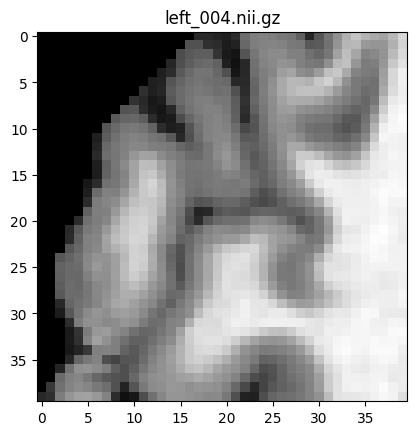

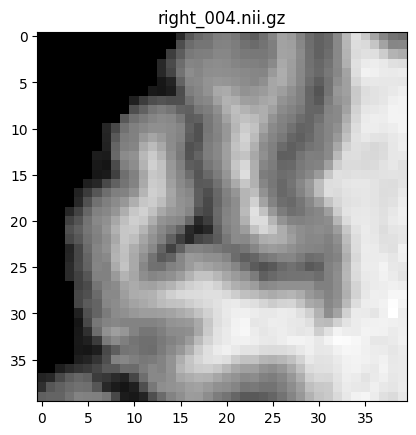

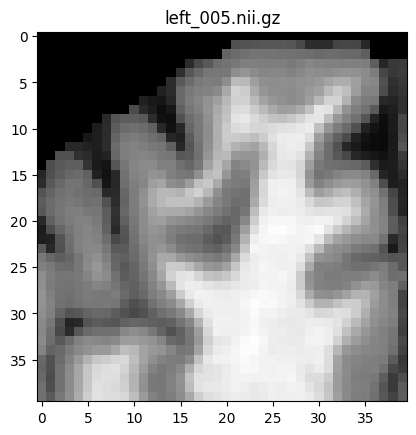

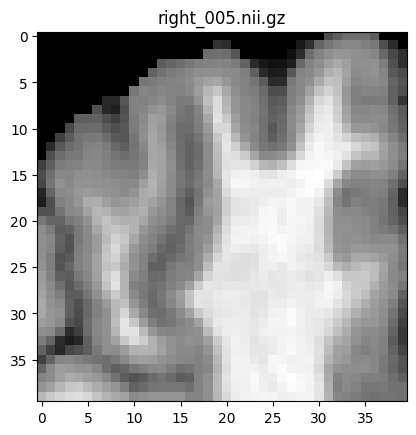

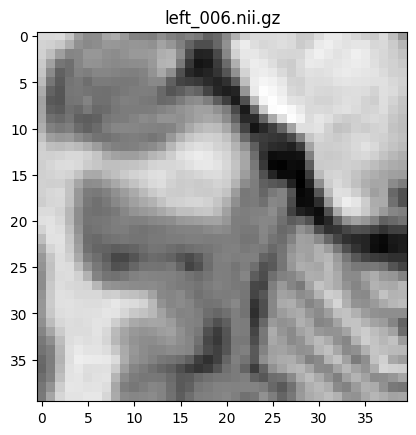

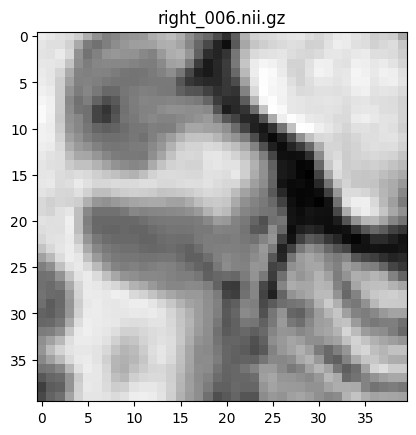

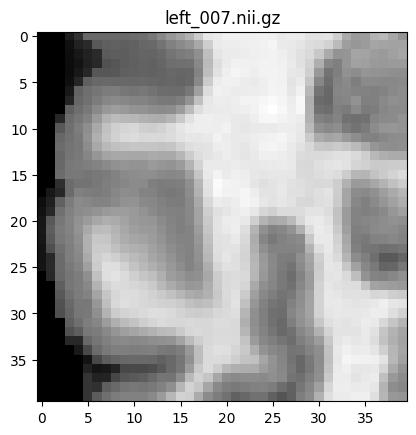

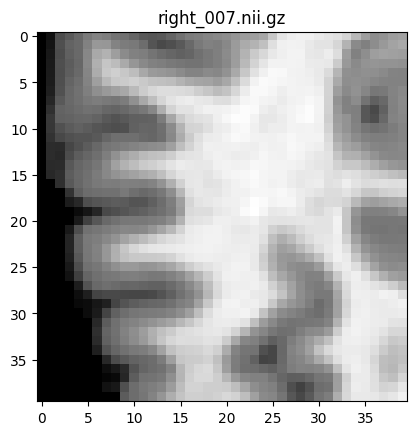

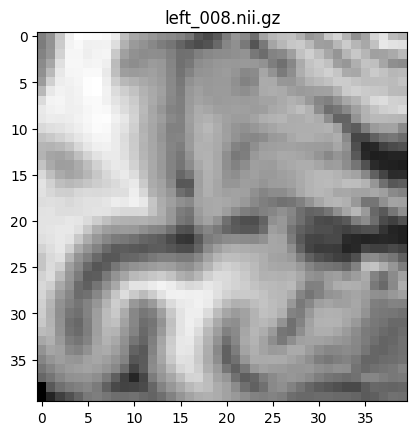

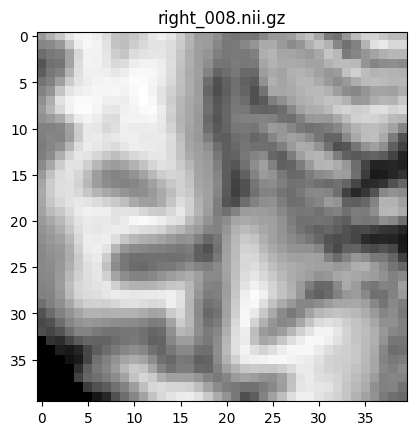

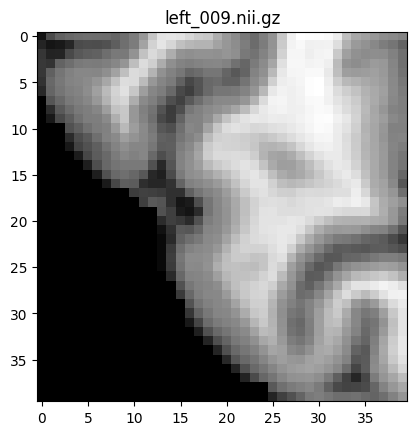

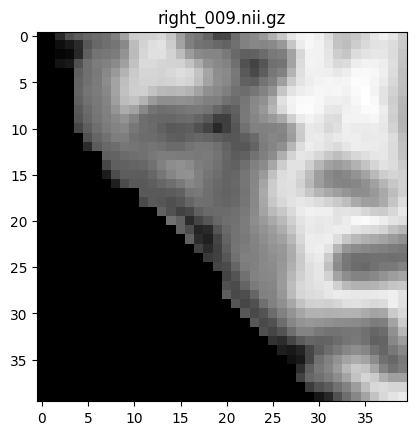

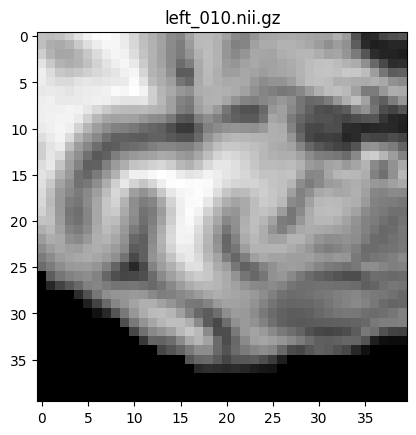

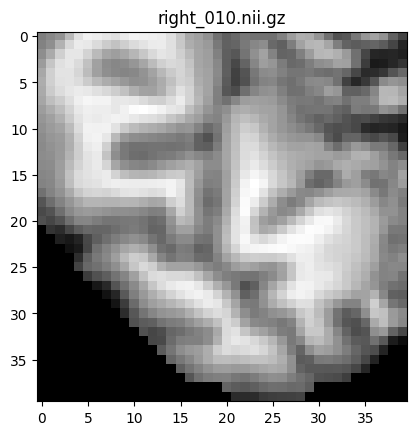

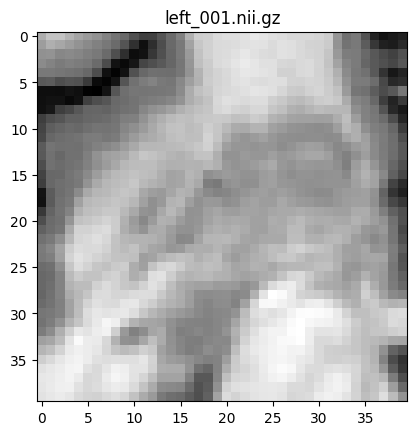

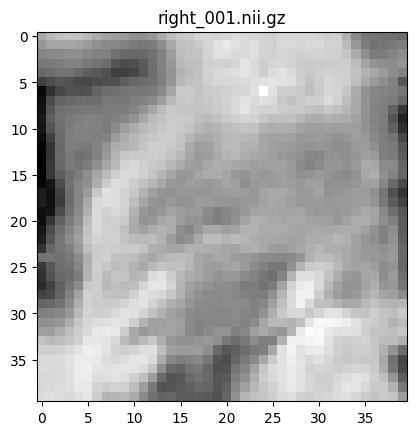

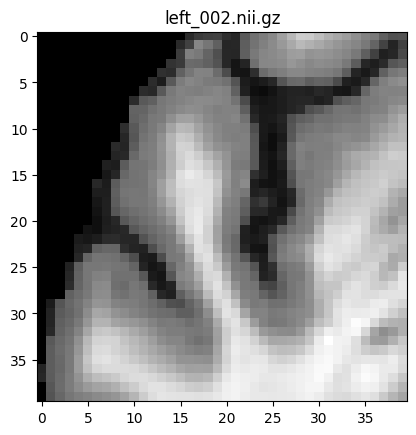

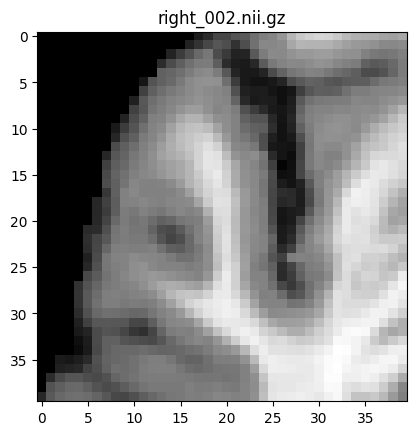

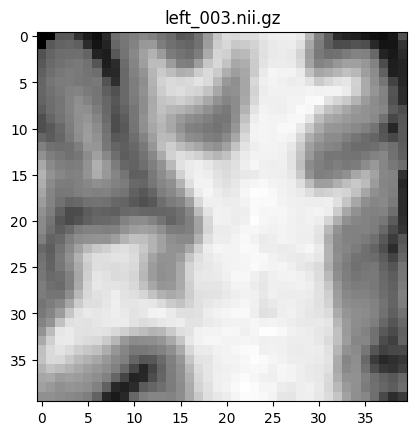

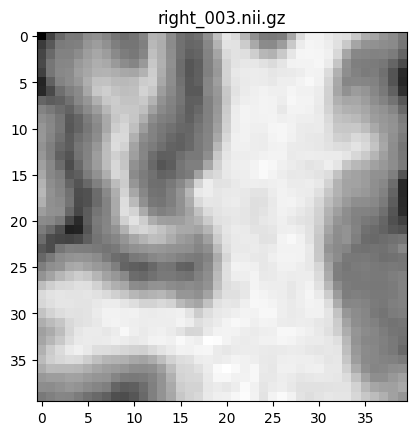

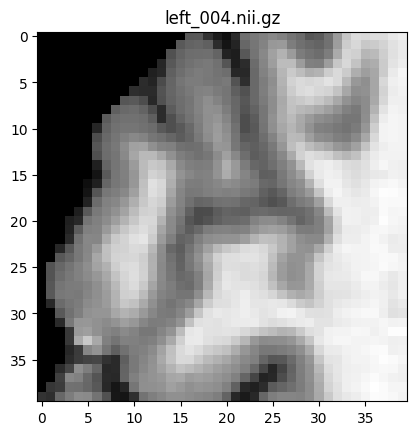

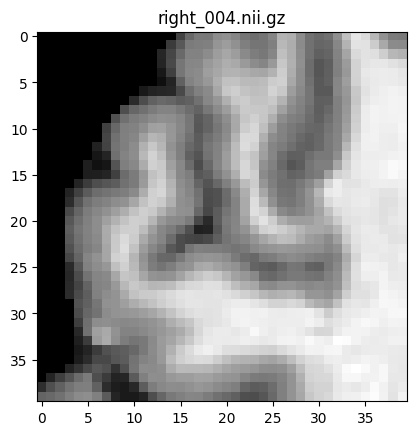

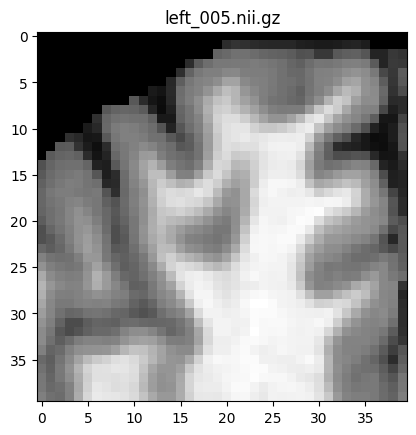

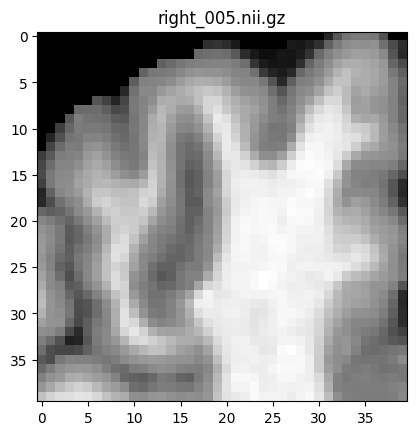

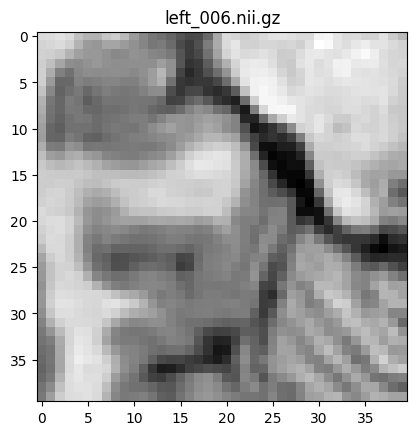

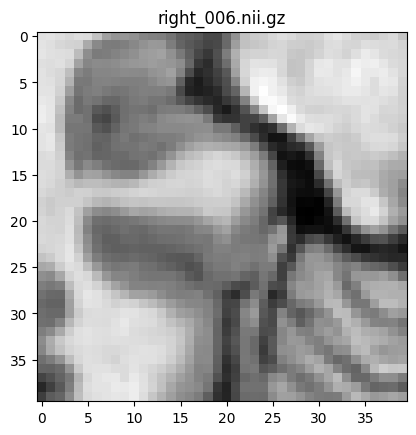

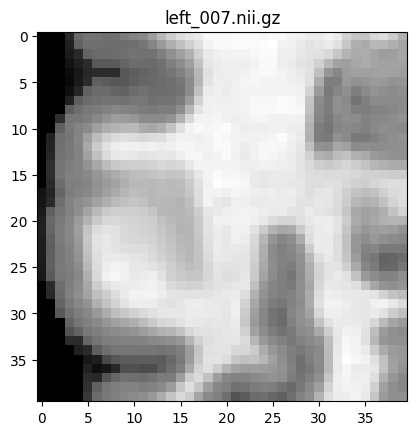

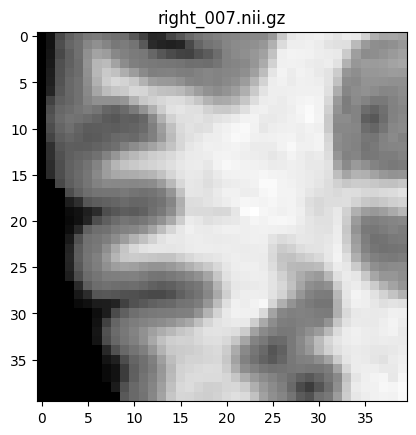

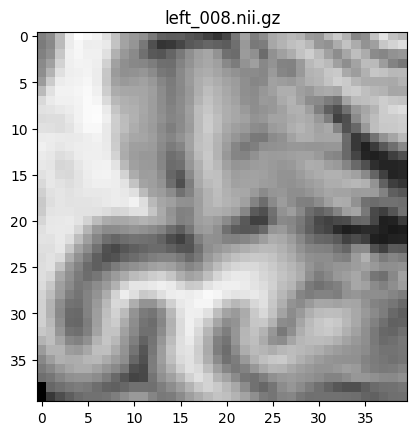

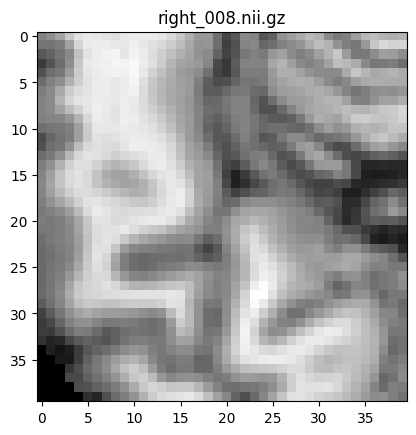

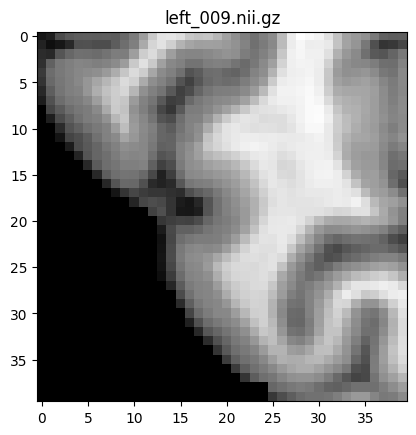

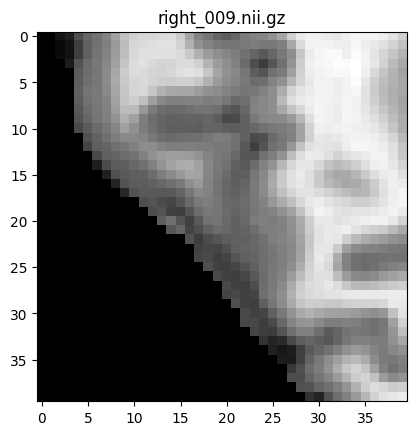

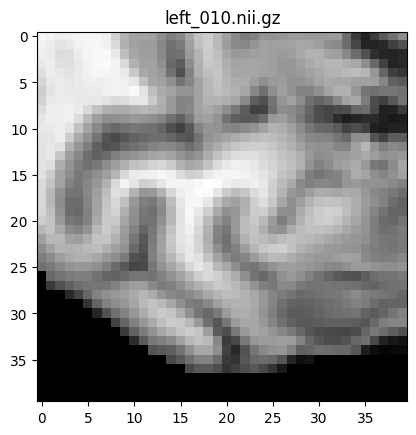

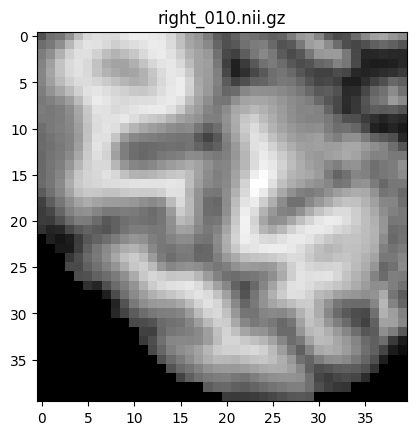

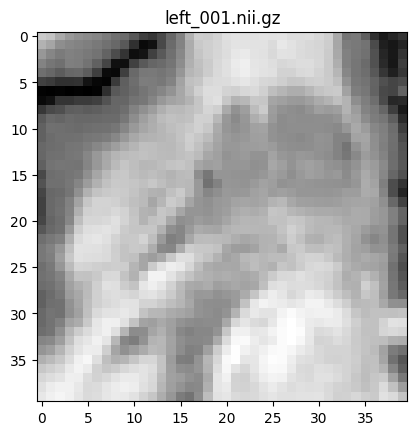

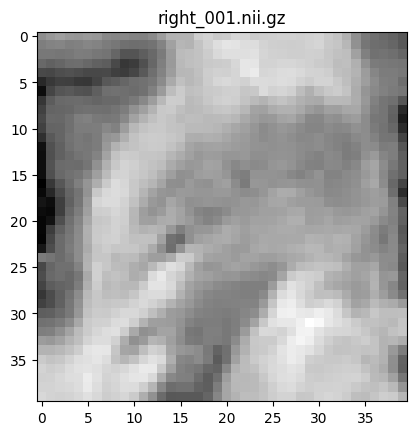

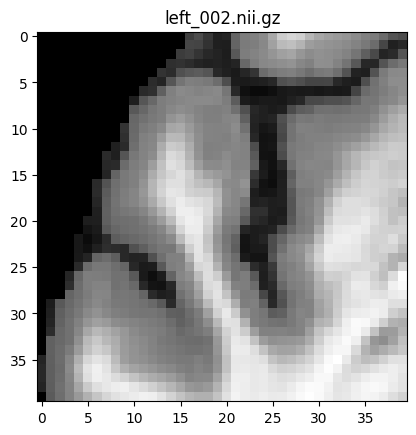

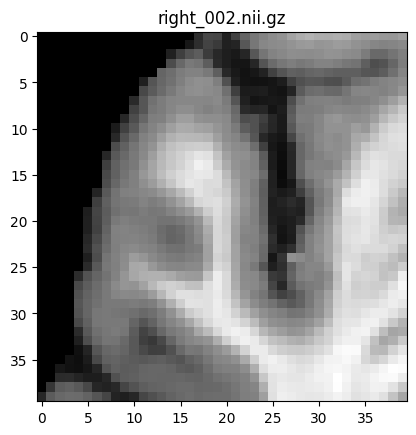

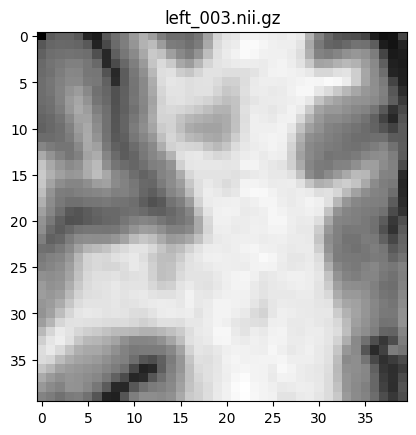

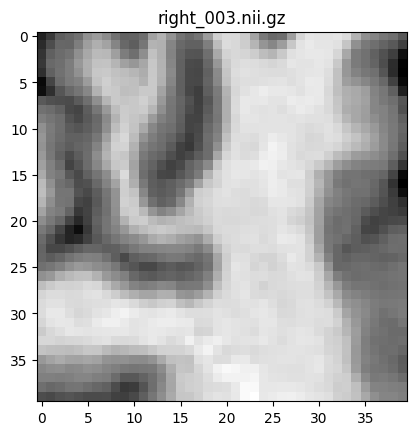

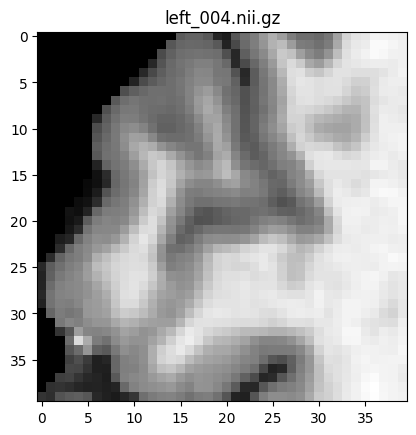

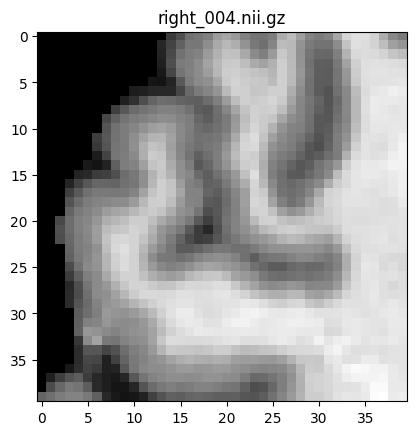

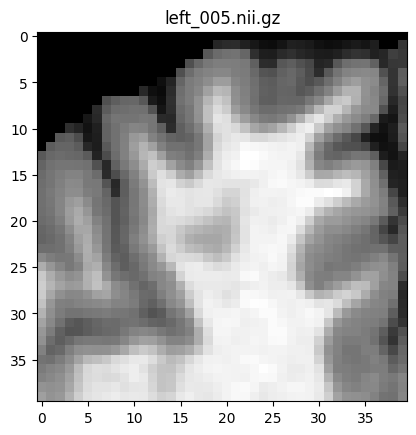

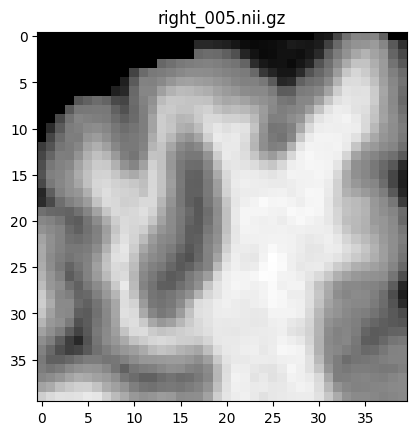

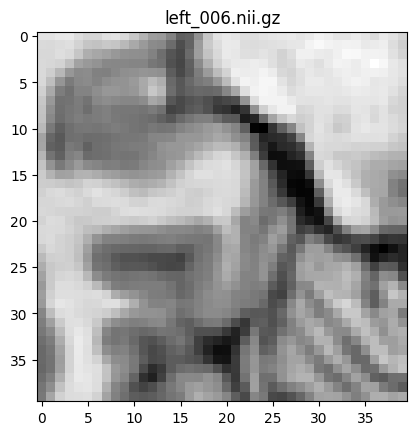

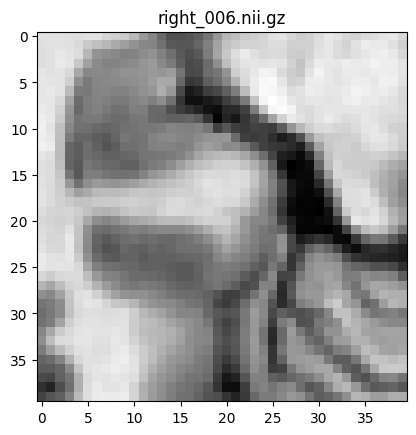

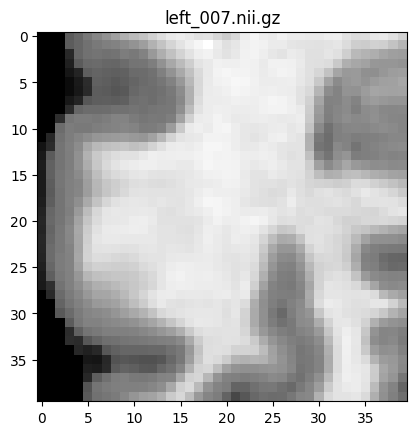

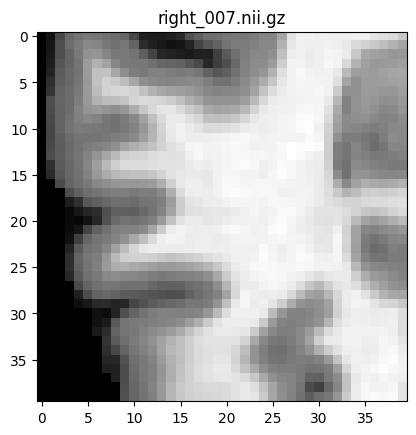

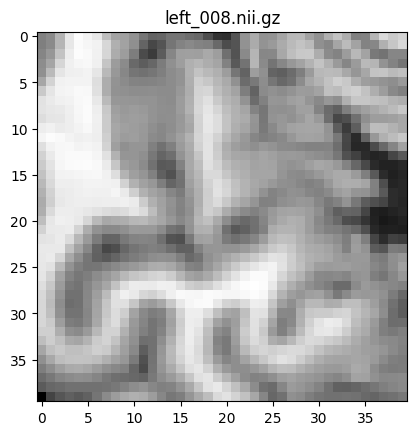

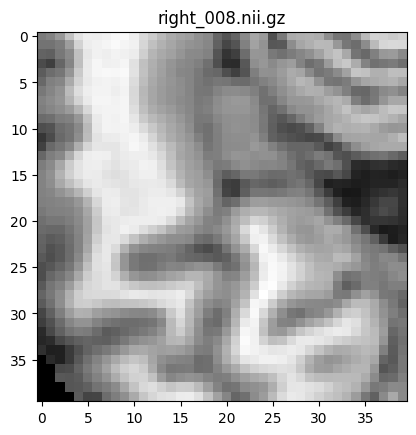

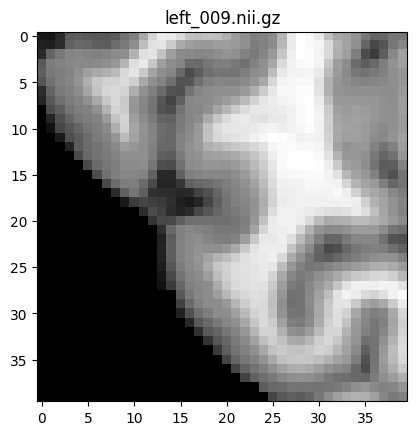

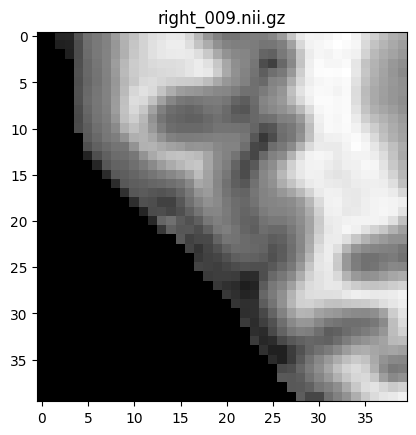

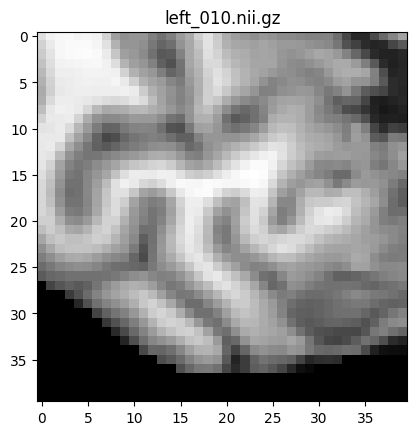

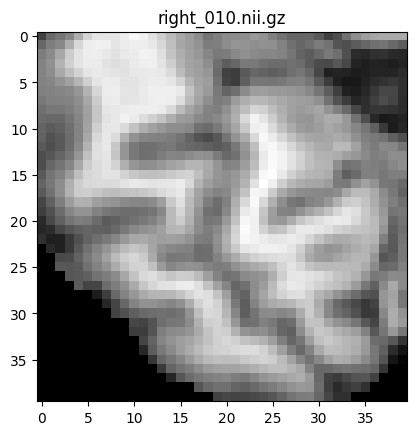

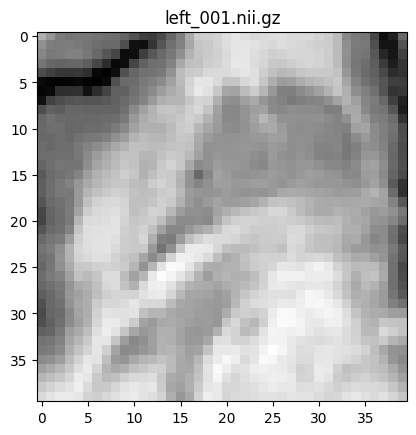

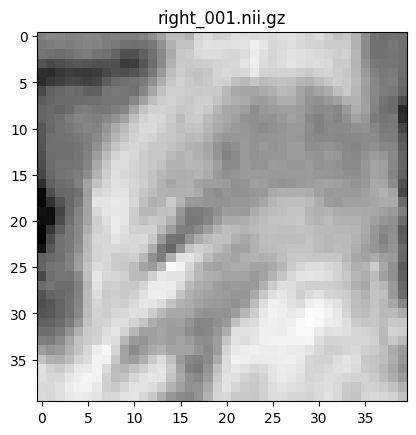

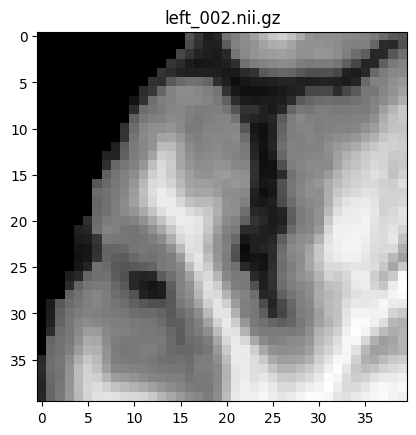

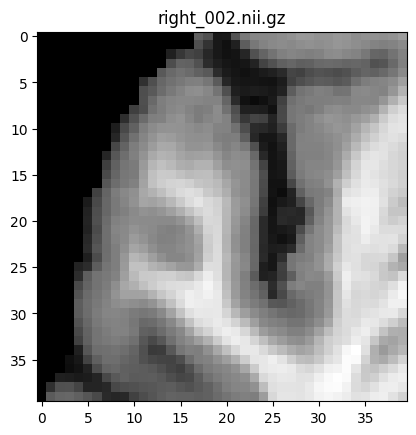

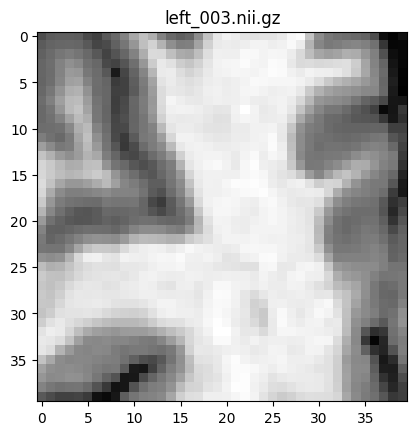

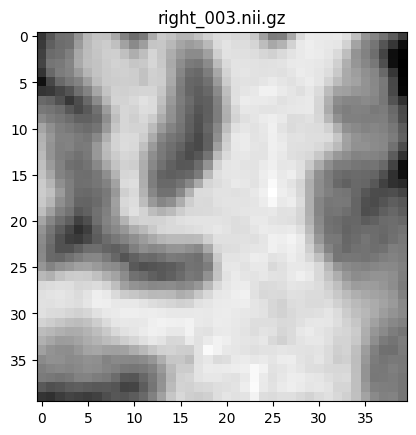

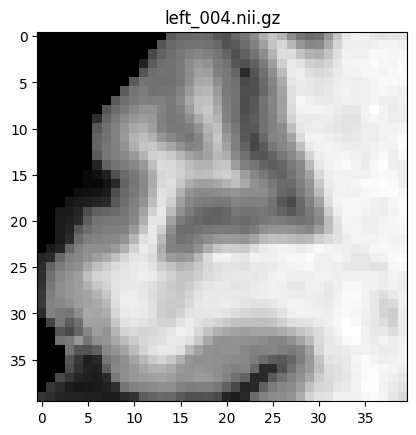

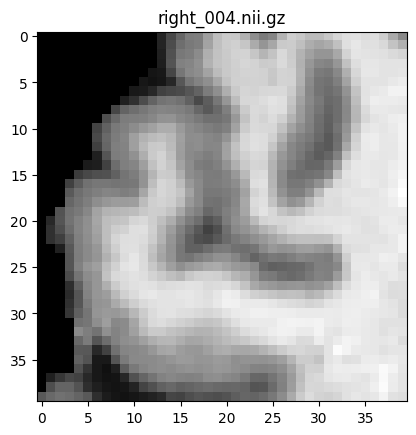

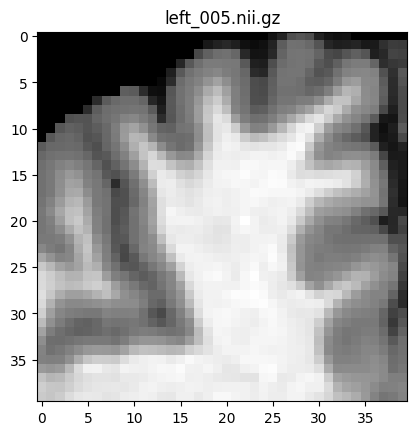

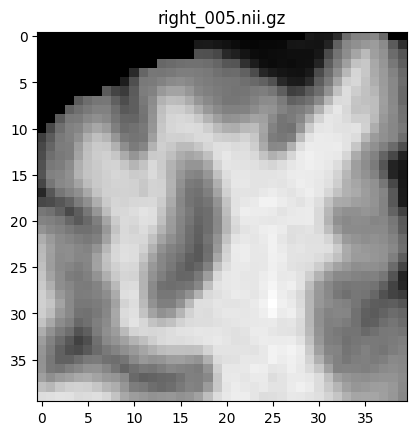

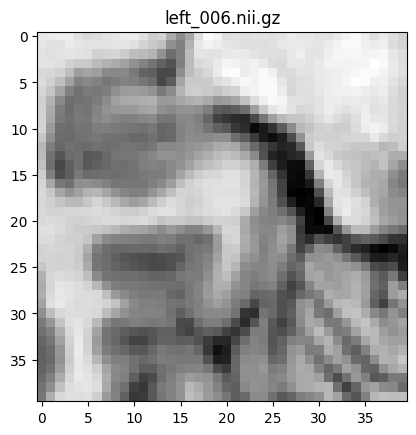

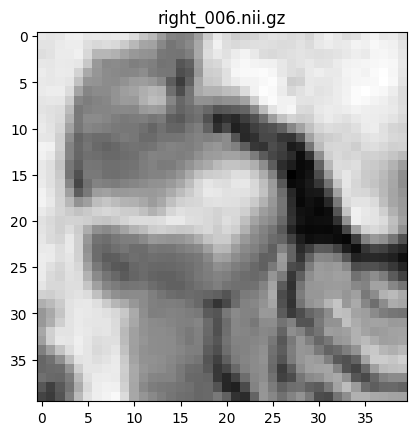

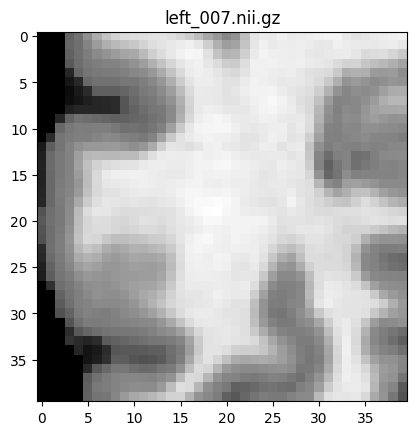

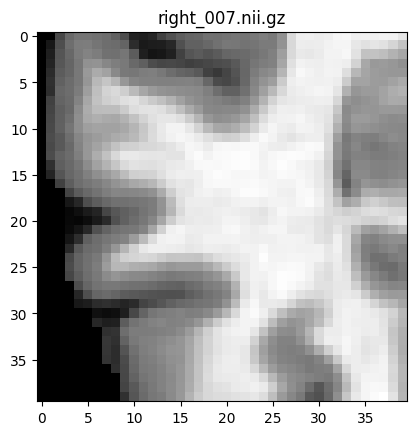

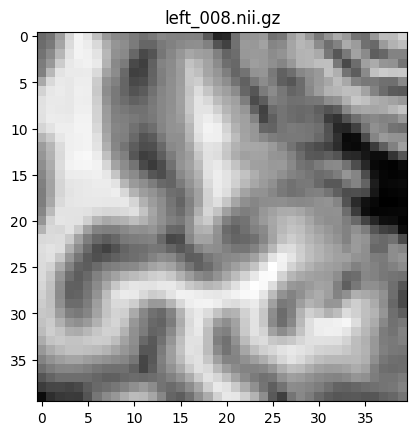

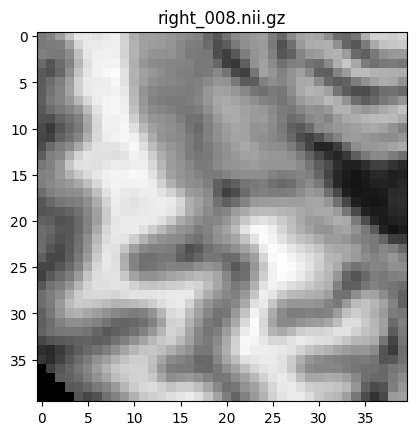

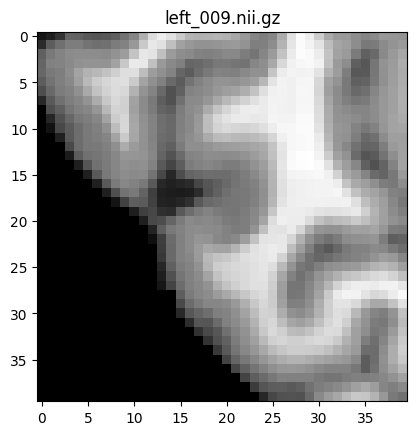

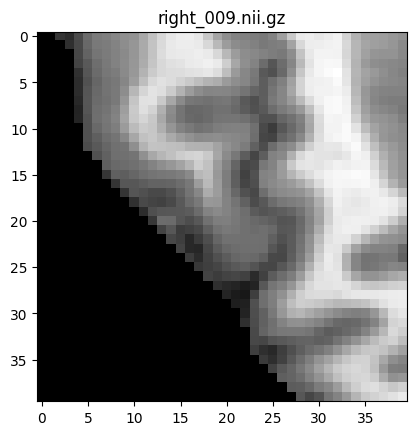

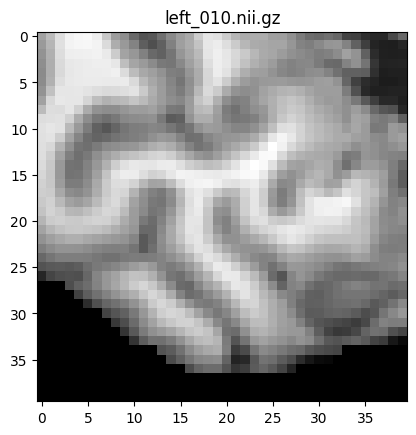

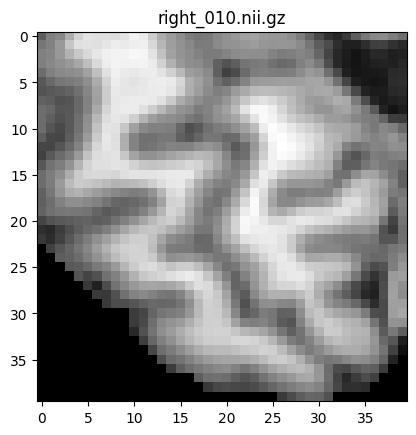

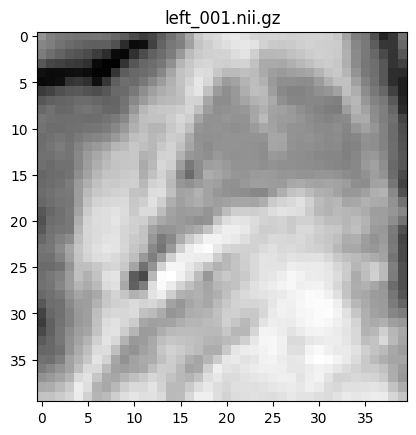

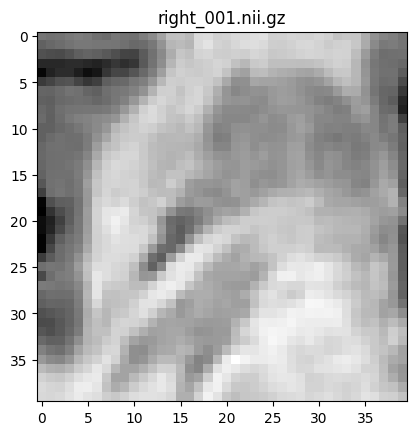

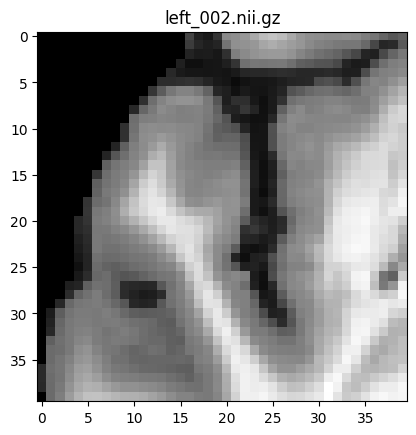

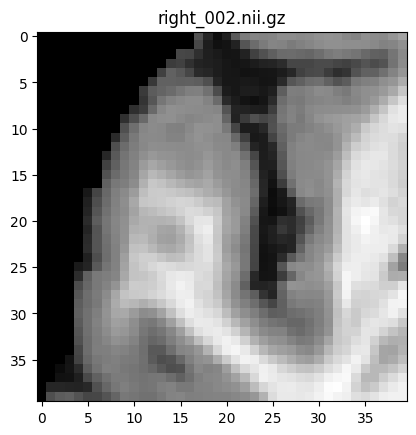

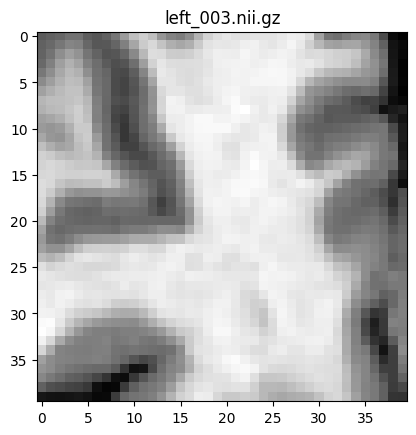

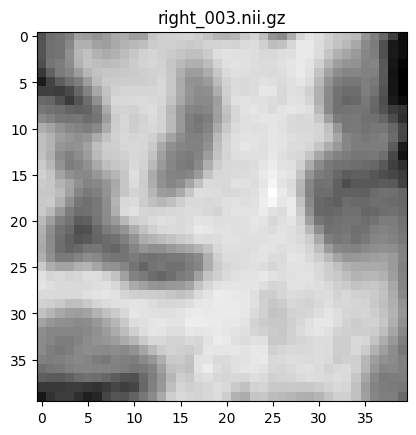

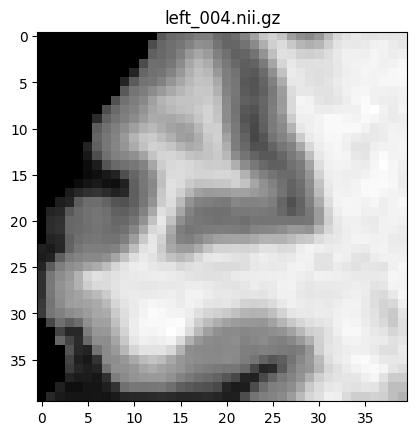

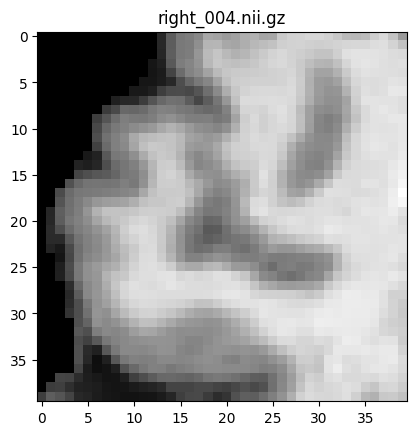

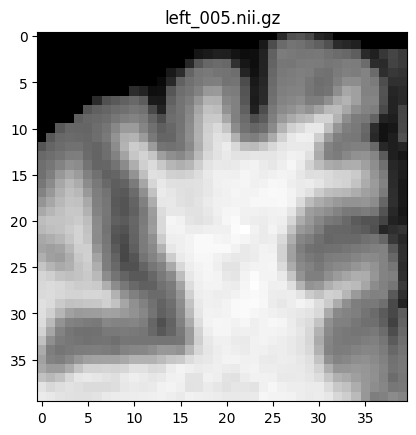

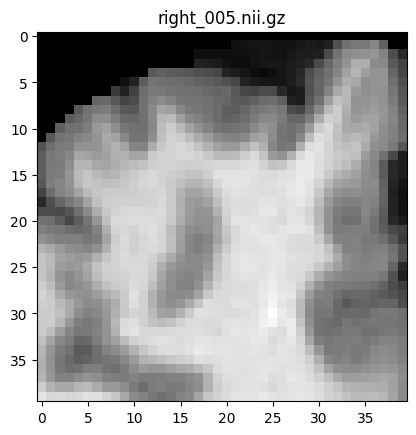

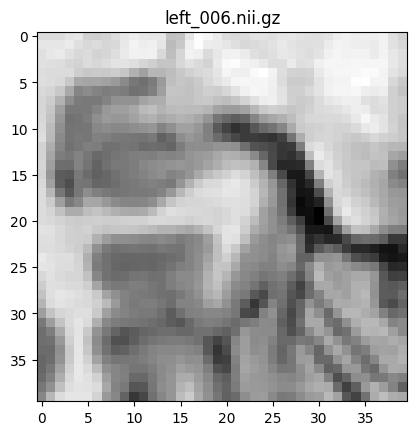

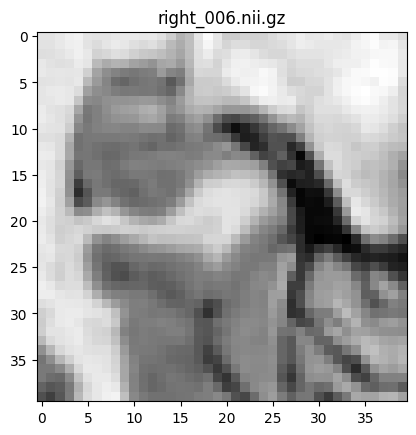

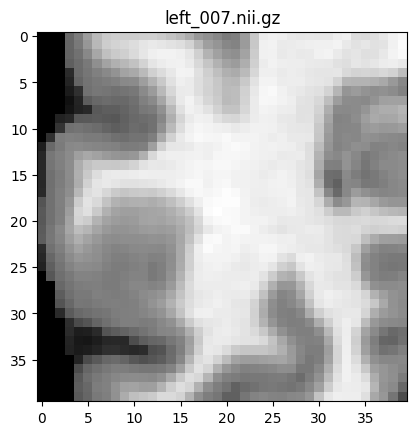

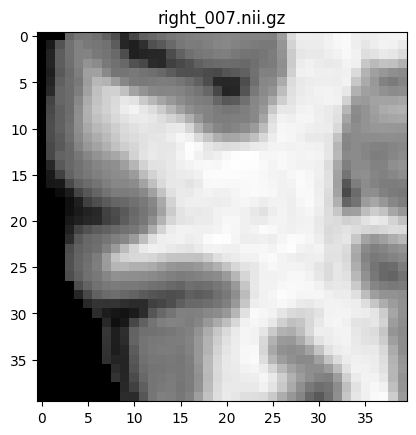

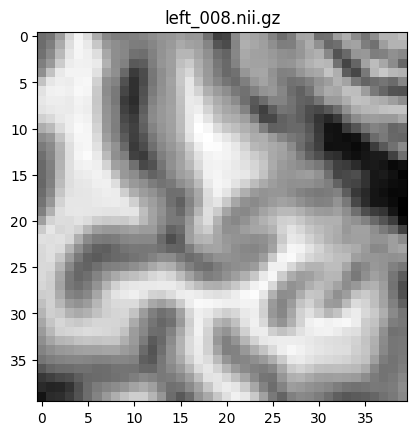

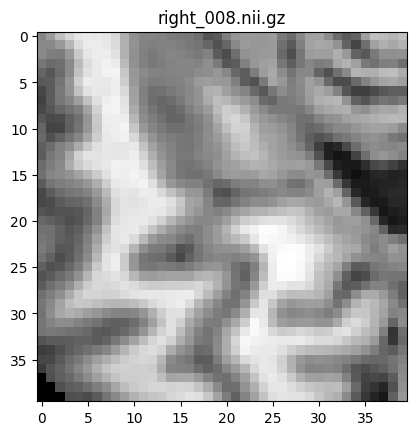

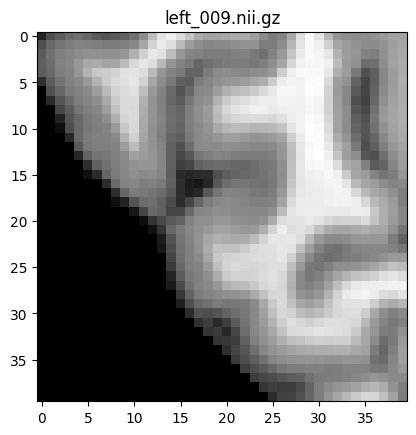

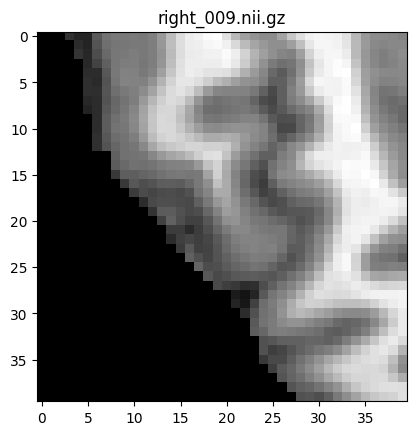

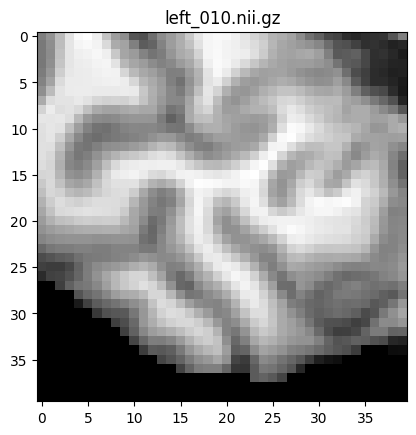

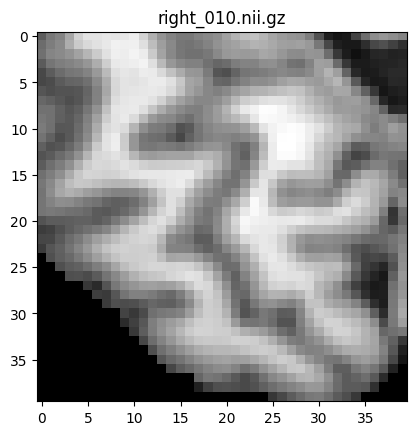

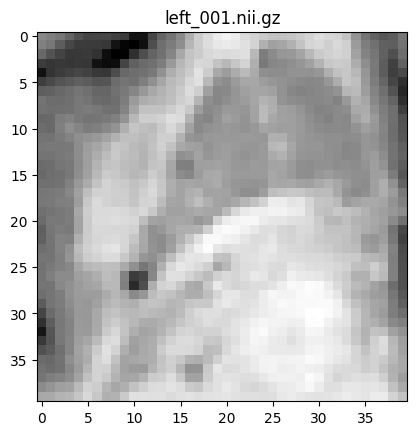

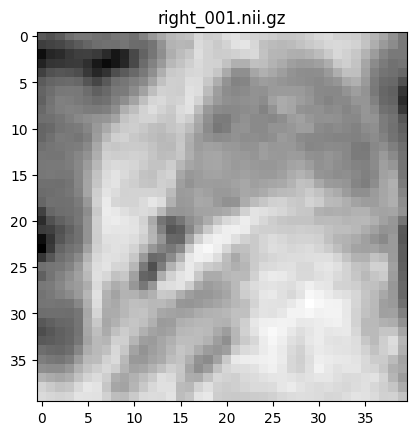

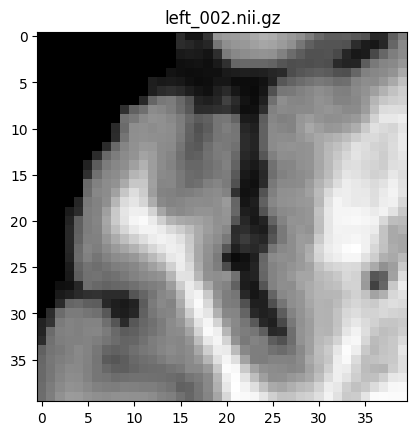

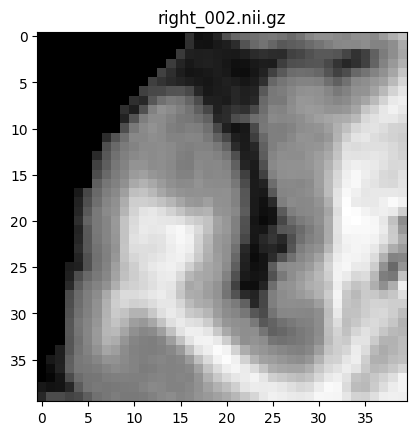

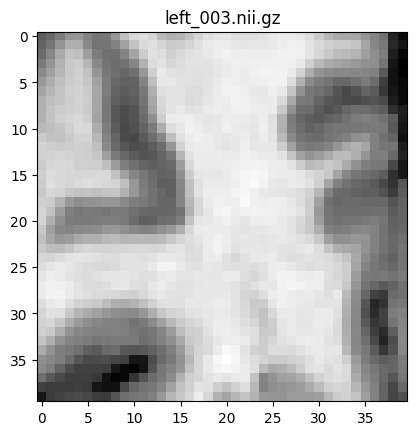

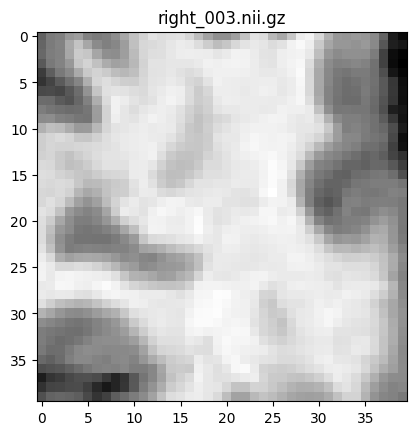

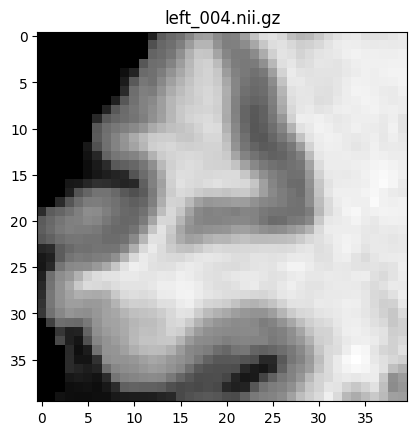

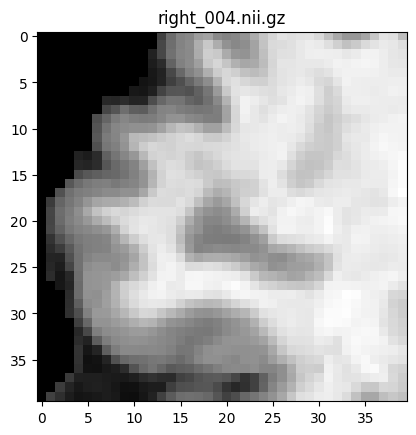

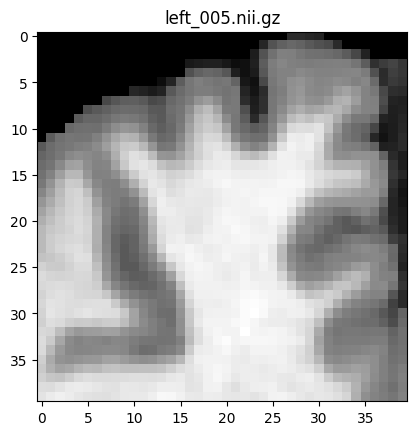

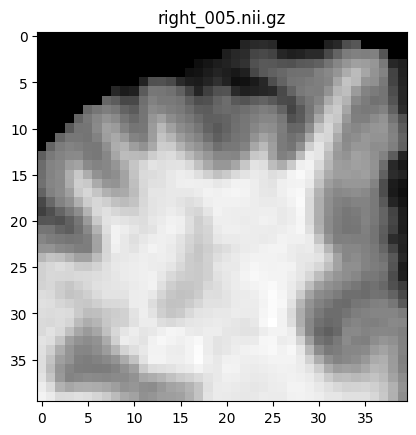

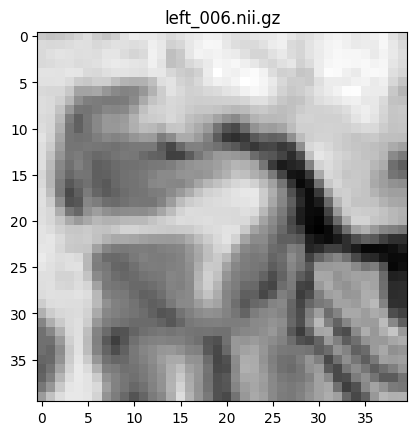

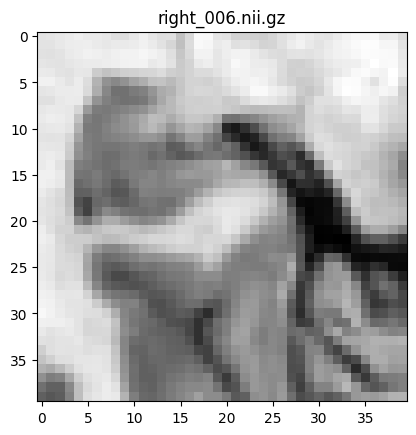

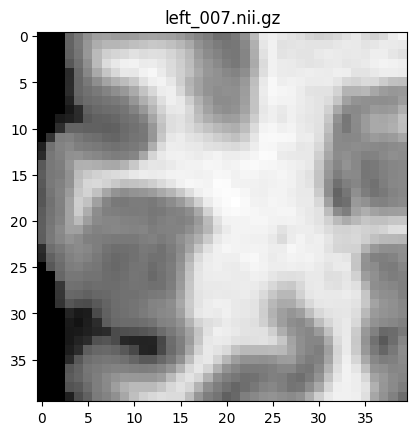

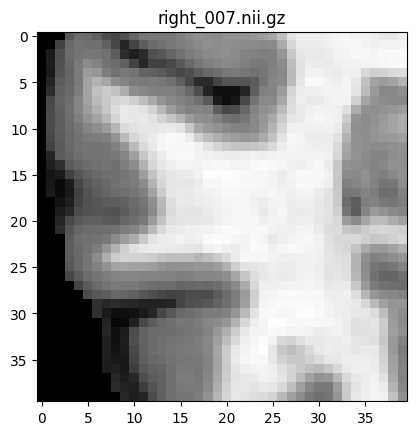

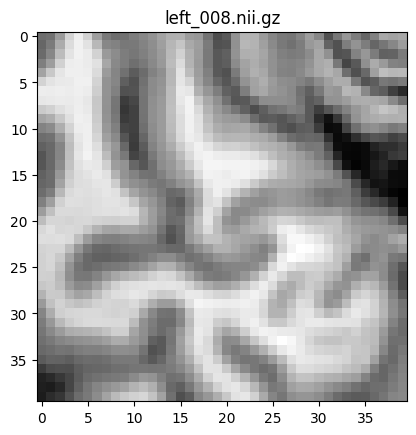

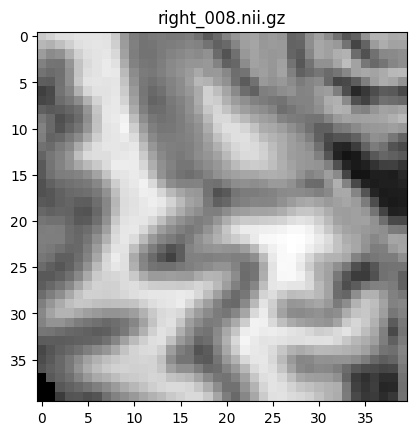

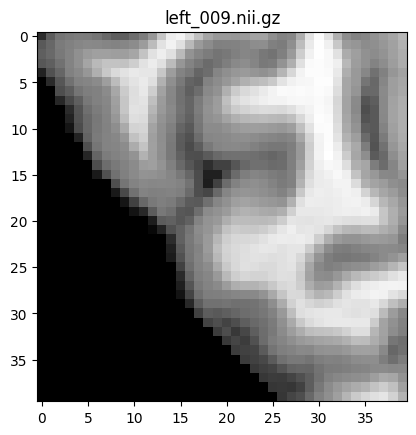

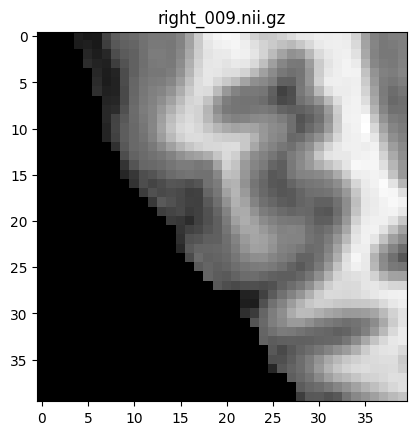

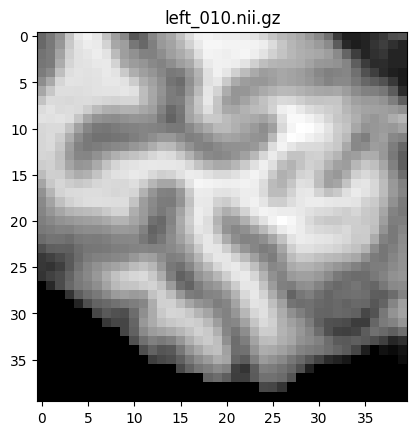

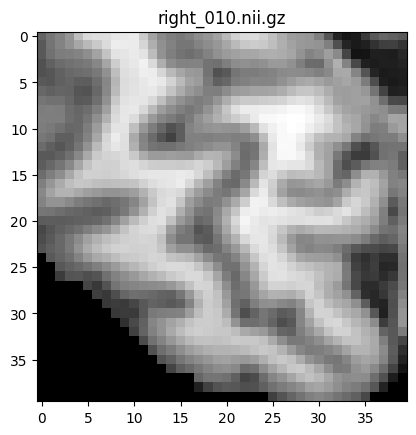

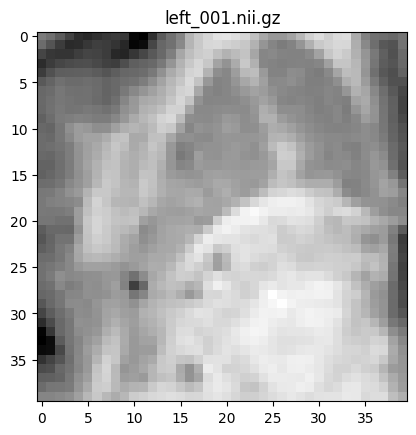

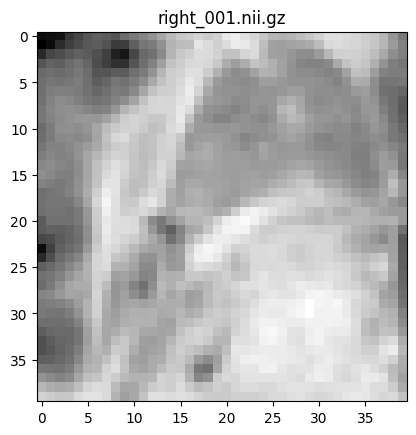

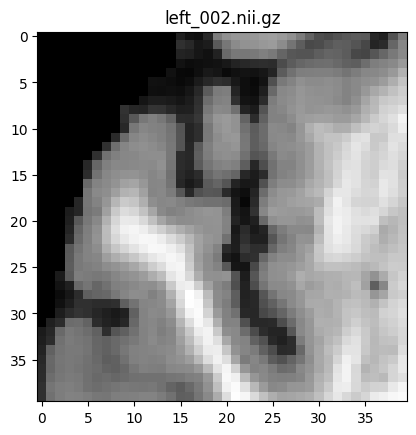

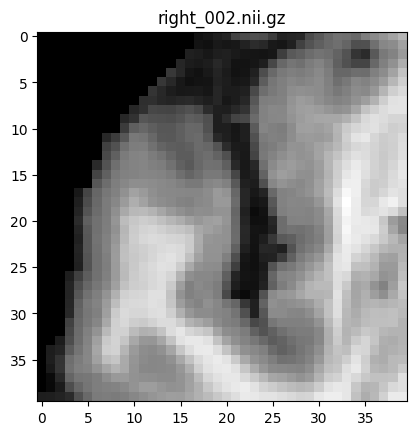

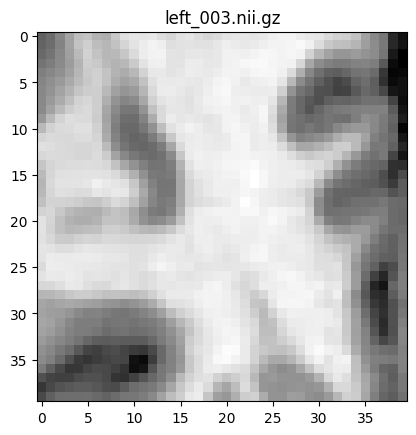

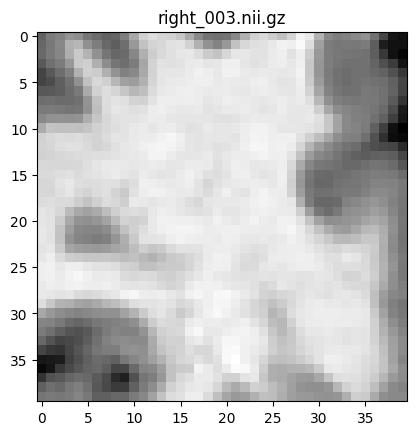

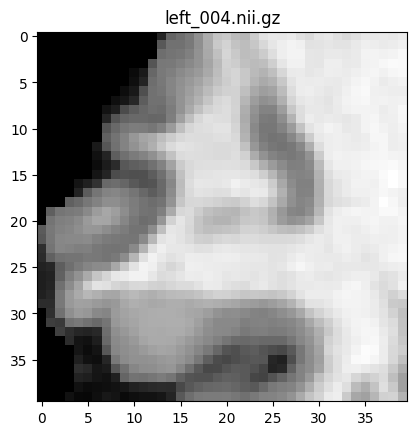

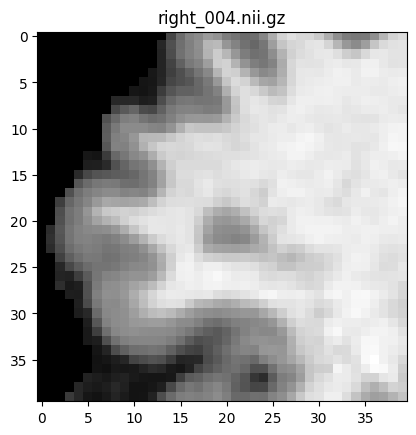

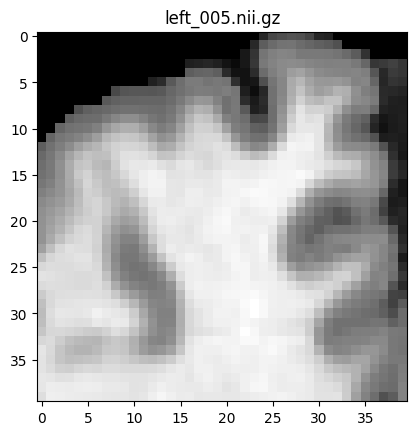

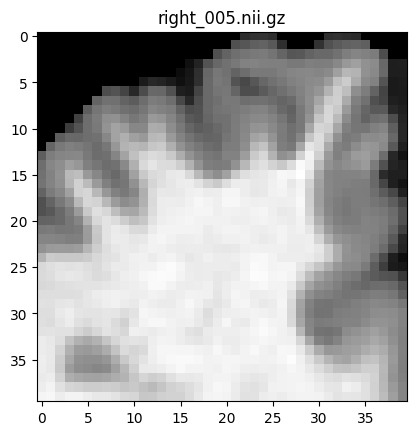

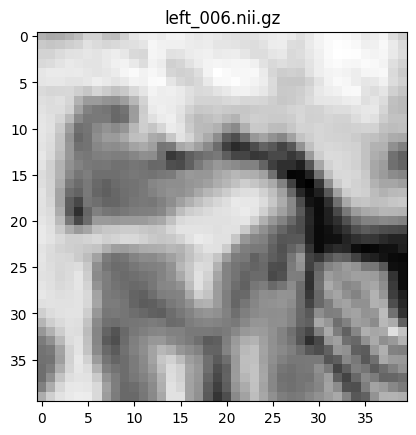

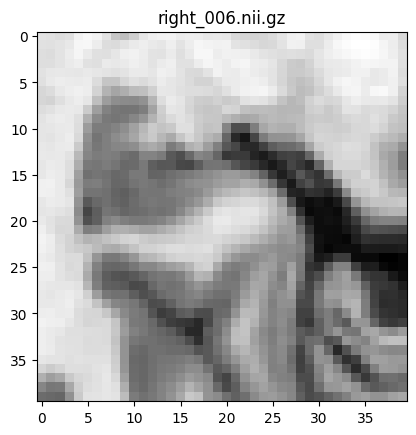

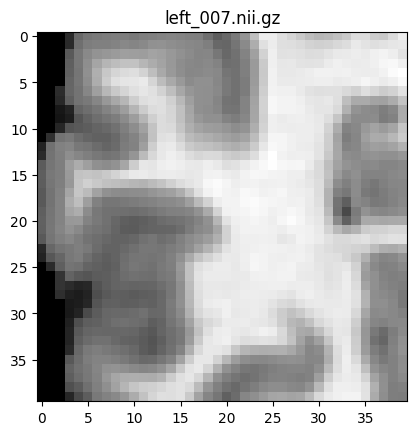

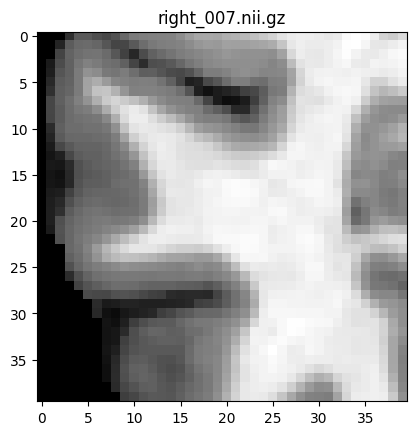

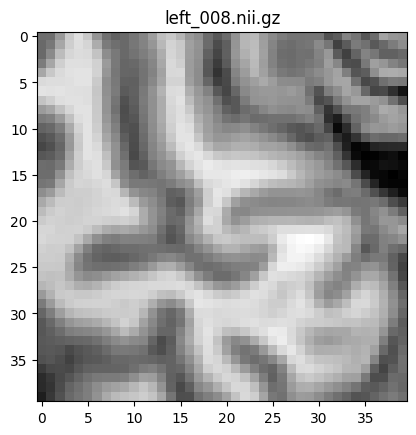

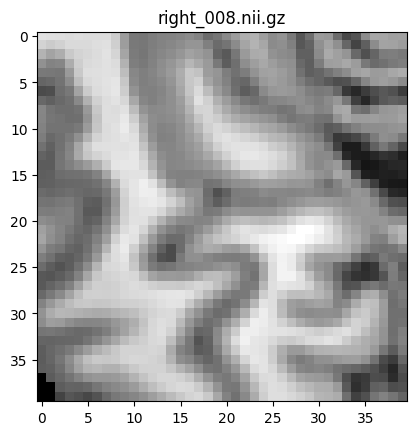

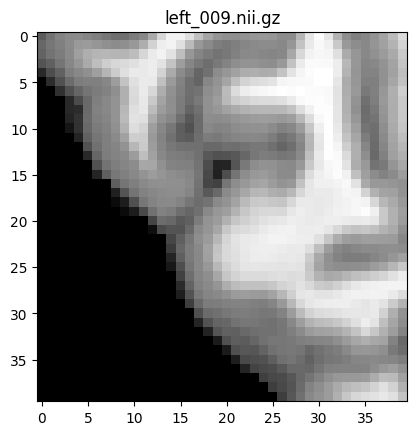

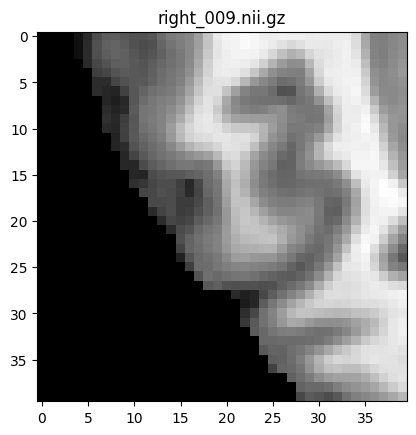

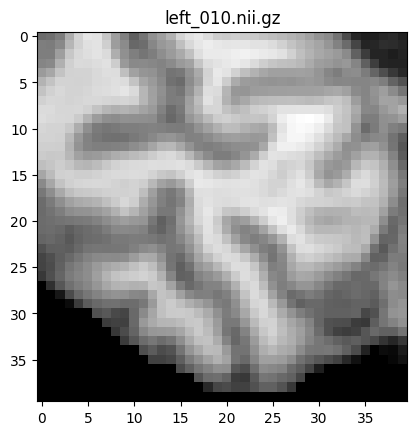

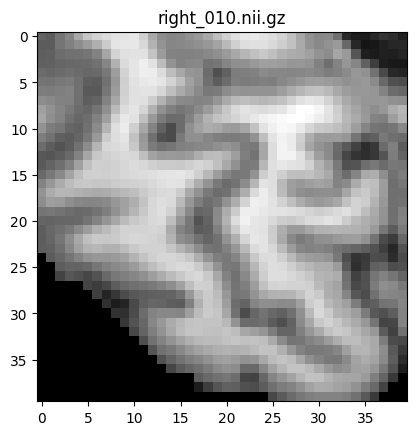

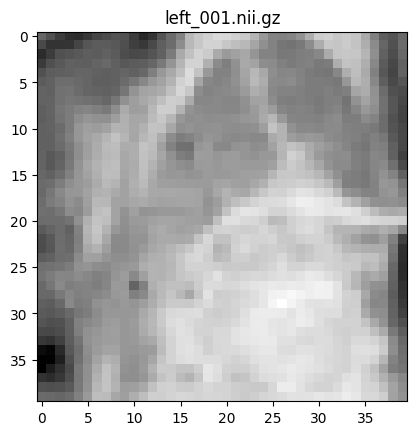

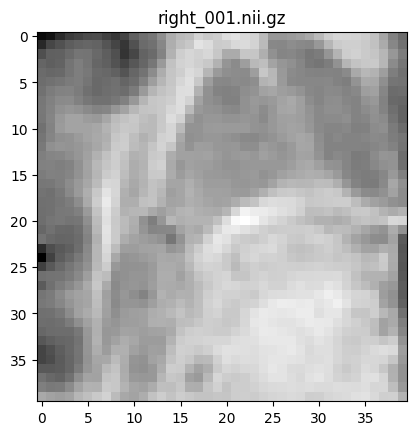

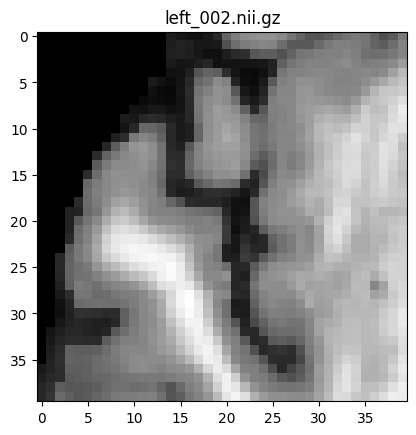

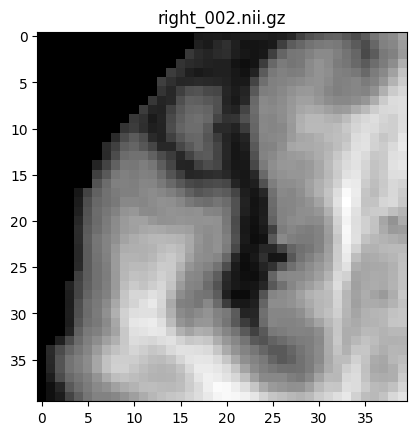

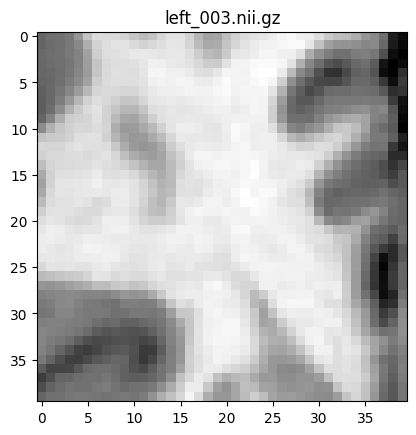

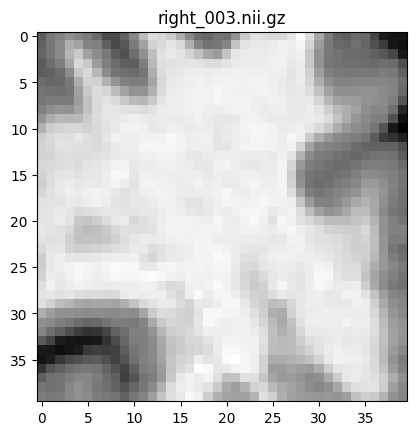

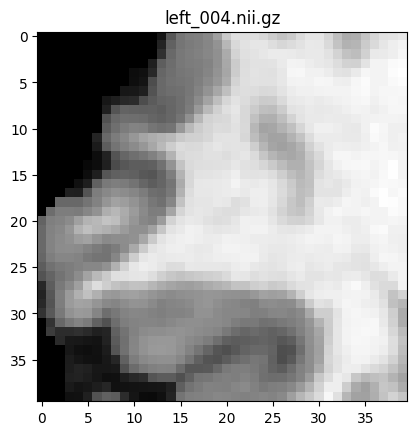

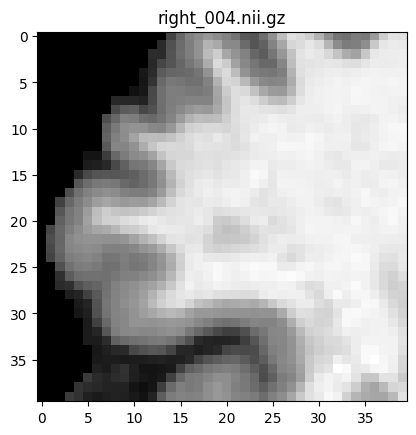

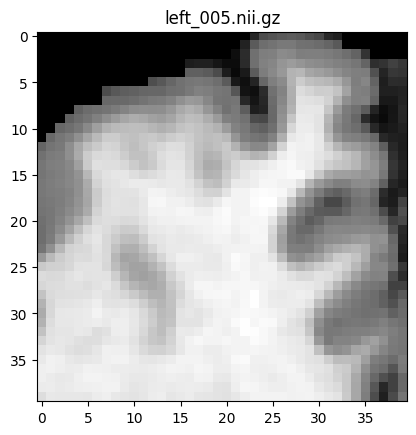

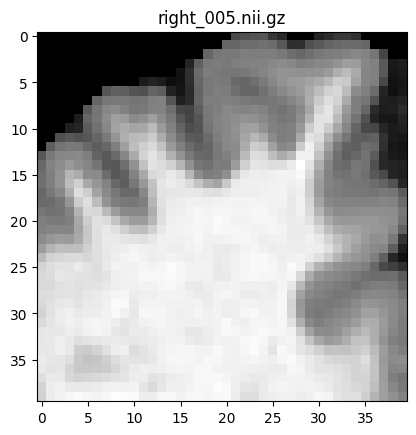

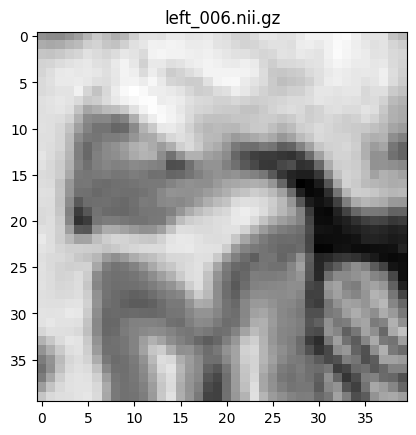

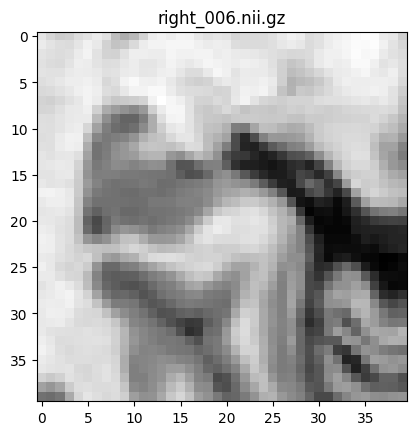

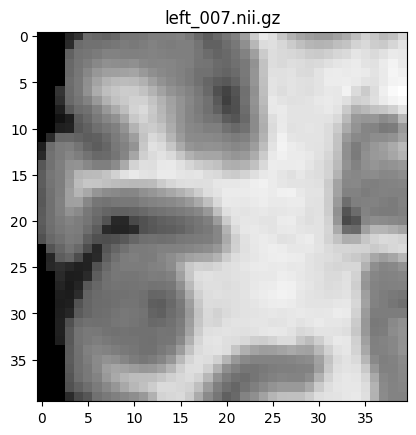

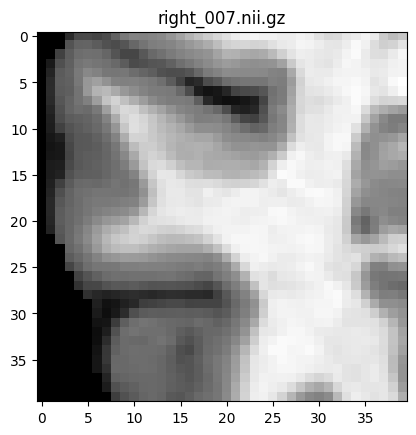

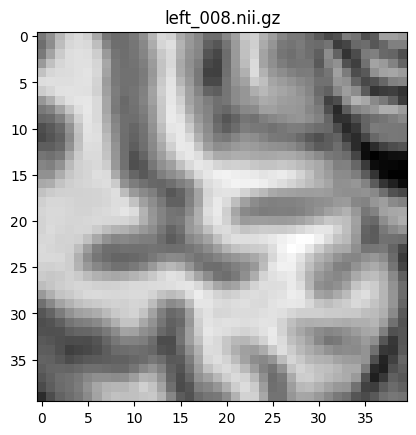

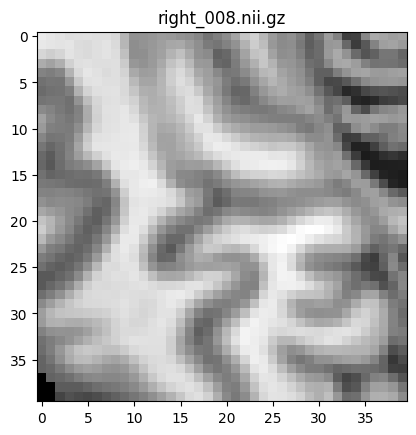

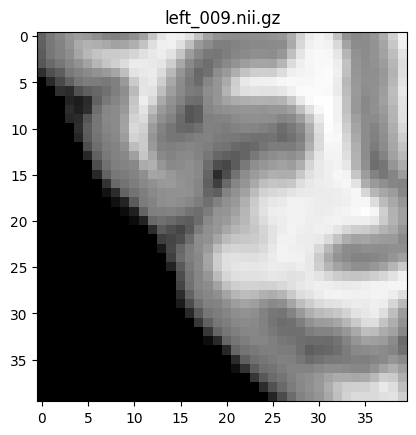

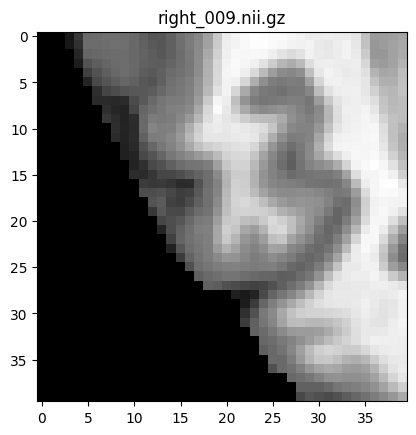

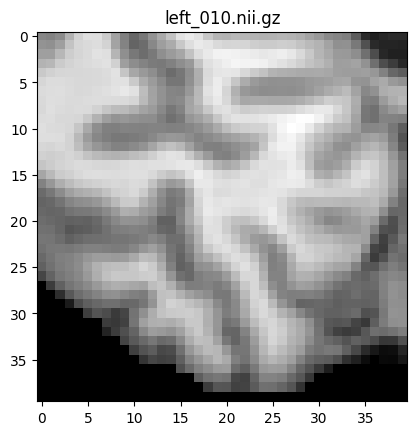

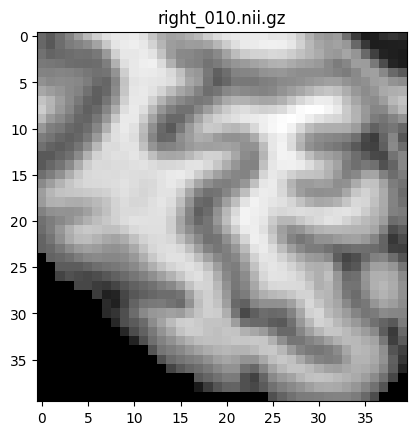

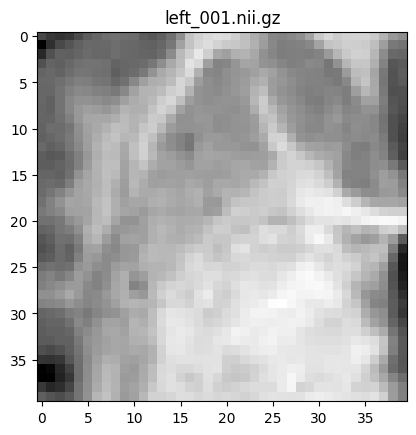

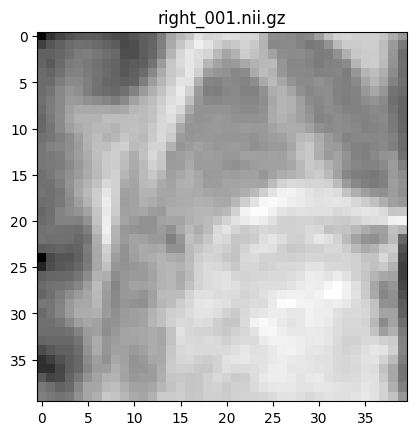

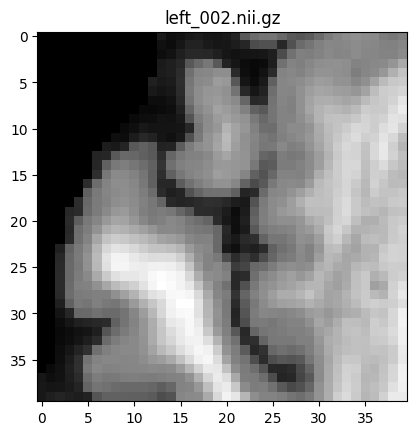

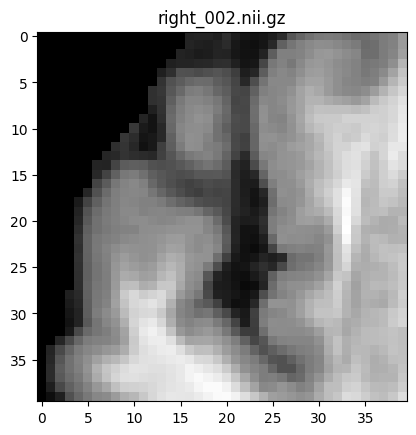

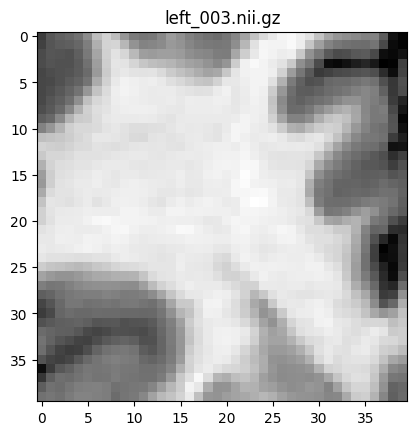

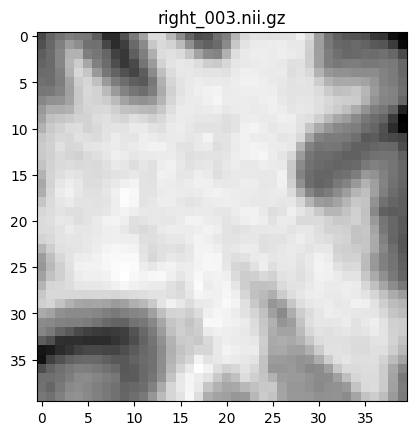

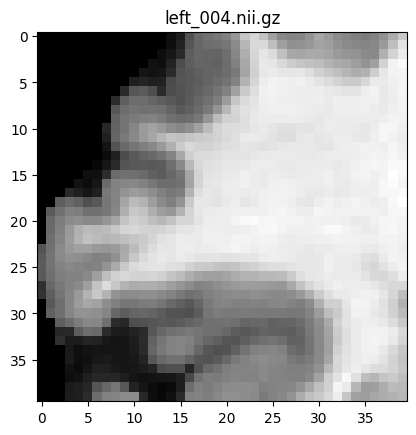

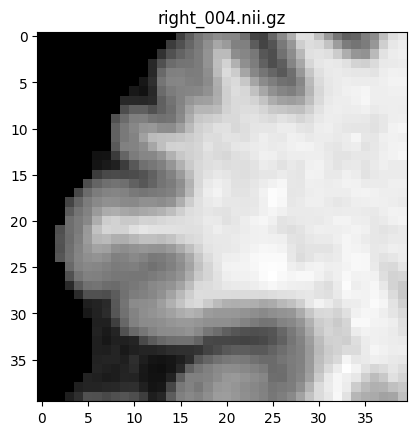

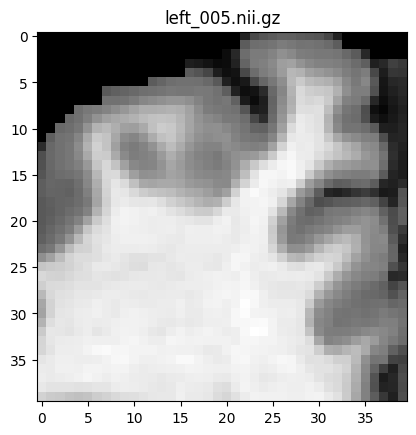

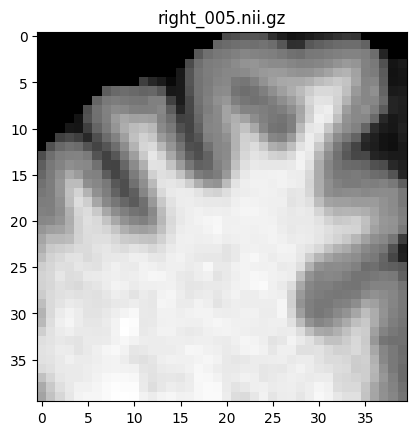

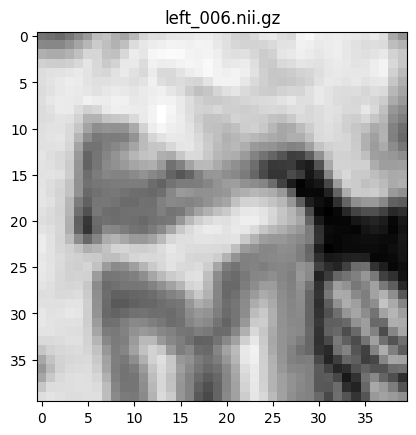

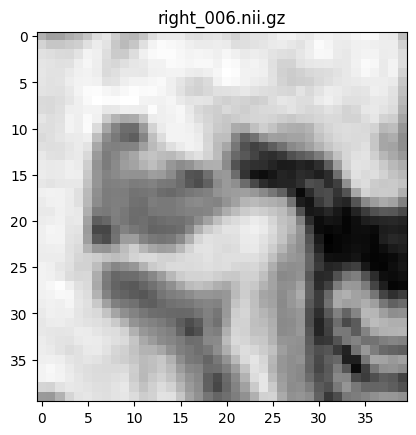

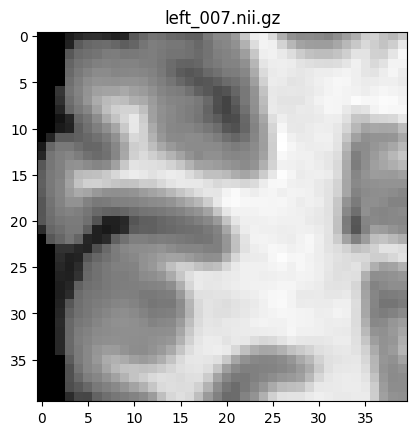

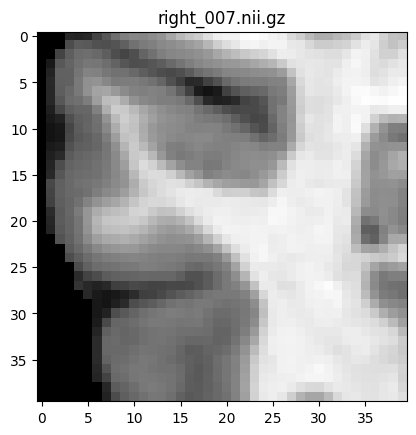

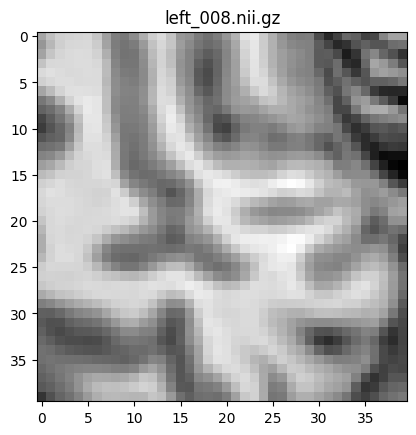

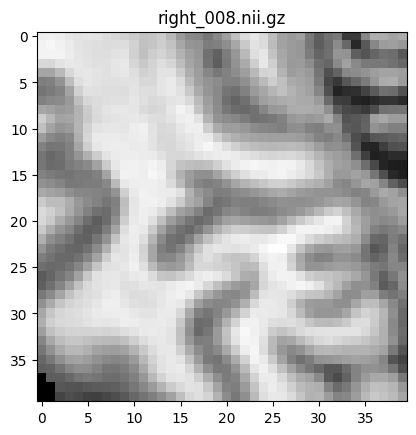

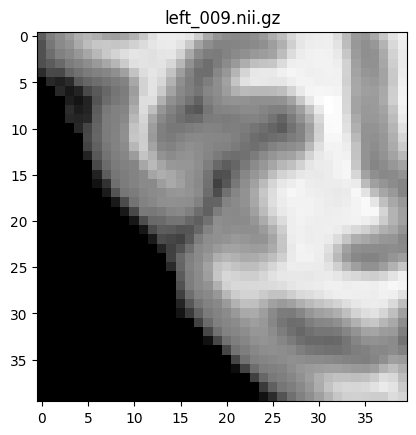

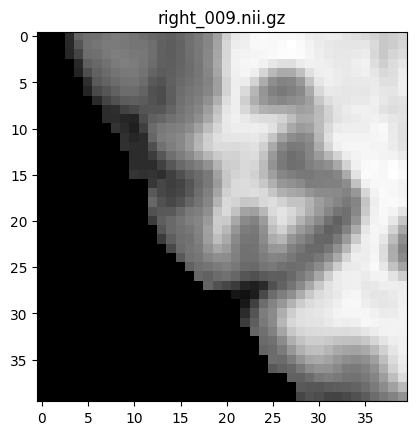

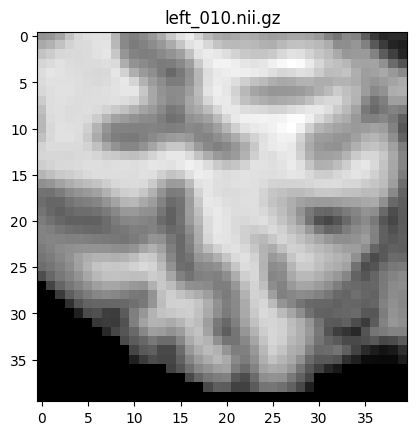

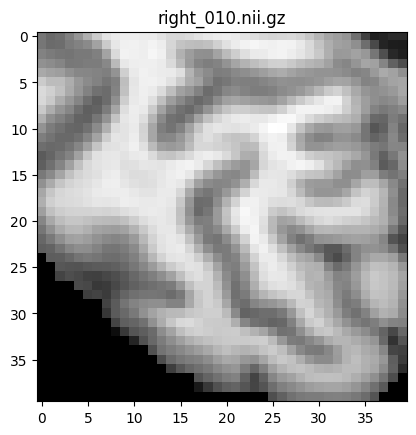

In [2]:
base = 'Novo_Contralateral'
cont = 0

for patient in ['sub-60K04']:
    folder_left = os.path.join(base, patient, 'left')
    folder_right = os.path.join(base, patient, 'right')
    for slices in os.listdir(folder_left):
        cont+=1
        if cont < 48 or cont > 56:
            continue
        path_left = os.path.join(folder_left, slices)
        path_right = os.path.join(folder_right, slices)
        for item in os.listdir(path_left):
            name = item.removesuffix(".nii.gz")
            idx = name.split("_")[1]
            name_right = f"right_{idx}.nii.gz"
            nib1 = nib.load(os.path.join(path_left, item)).get_fdata()
            nib2 = nib.load(os.path.join(path_right, name_right)).get_fdata()
            plt.title(f"{item}")
            plt.imshow(nib1, cmap='gray')
            plt.show()
            plt.title(f"{name_right}")
            plt.imshow(np.fliplr(nib2), cmap='gray')
            plt.show()

In [3]:
def calculate_label(image, threshold=0.04):
    """
    Determina o label da subimagem com base no percentual de fundo não-preto.
    :param subimage: Array da subimagem.
    :param threshold: Percentual mínimo de fundo não-preto para considerar como label 1.
    :return: String indicando o label.
    """
    # Total de pixels na subimagem
    total_pixels = image.size
    # Número de pixels não-preto
    non_zero_pixels = np.count_nonzero(image)
    # Proporção de pixels não-preto
    non_black_ratio = non_zero_pixels / total_pixels if total_pixels > 0 else 0
    
    # Verifica se há lesão e se o fundo não-preto é maior que o limiar
    if np.any(image == 1) and non_black_ratio >= threshold:
        return 1
    else:
        return 0

def load_patient_data(folder, patient_id):
    """
    Carrega os dados de um único paciente (imagens, máscaras e labels) de um diretório.

    Args:
        folder (str): Caminho da pasta contendo os dados dos pacientes.
        patient_id (str): ID do paciente a ser carregado.

    Returns:
        dict: Dados do paciente, incluindo imagens, máscaras e labels para os lados esquerdo e direito.
              Retorna None se o paciente não for encontrado.
    """
    patient_path = os.path.join(folder, patient_id)
    if not os.path.exists(patient_path):
        print(f"Paciente {patient_id} não encontrado na pasta {folder}.")
        return None

    # Inicializa estruturas para armazenar os dados do paciente
    patient_data = {
        "images_left": [],
        "images_right": [],
        "mask_left": [],
        "mask_right": [],
        "labels_left": [],
        "labels_right": [],
    }

    areas_image = ["left", "right"]
    areas_mask = ["lesion_left", "lesion_right"]
    path_left = os.path.join(patient_path, areas_image[0])
    path_right = os.path.join(patient_path, areas_image[1])
    lesion_path_left = os.path.join(patient_path, areas_mask[0])
    lesion_path_right = os.path.join(patient_path, areas_mask[1])

    # Verifica se os diretórios existem
    if not os.path.exists(path_left) or not os.path.exists(path_right) or \
       not os.path.exists(lesion_path_left) or not os.path.exists(lesion_path_right):
        print(f"Estrutura de diretórios inválida para o paciente {patient_id}.")
        return None

    # Carrega as imagens e máscaras do lado esquerdo e direito
    for patch_id_left, mask_id_left, patch_id_right, mask_id_right in zip(
        os.listdir(path_left), os.listdir(lesion_path_left),
        os.listdir(path_right), os.listdir(lesion_path_right)
    ):
        img_path_left = os.path.join(path_left, patch_id_left)
        mask_path_left = os.path.join(lesion_path_left, mask_id_left)
        img_path_right = os.path.join(path_right, patch_id_right)
        mask_path_right = os.path.join(lesion_path_right, mask_id_right)

        for img_left, msk_left, img_right, msk_right in zip(
            os.listdir(img_path_left), os.listdir(mask_path_left),
            os.listdir(img_path_right), os.listdir(mask_path_right)
        ):
            # Carrega os dados do lado esquerdo
            data_left = nib.load(os.path.join(img_path_left, img_left)).get_fdata()
            data_msk_left = nib.load(os.path.join(mask_path_left, msk_left)).get_fdata()
            if len(data_left) > 0 or len(data_msk_left) > 0:
                patient_data["images_left"].append(data_left)
                patient_data["mask_left"].append(data_msk_left)
                patient_data["labels_left"].append(calculate_label(data_msk_left))

            # Carrega os dados do lado direito
            data_right = nib.load(os.path.join(img_path_right, img_right)).get_fdata()
            data_msk_right = nib.load(os.path.join(mask_path_right, msk_right)).get_fdata()
            if len(data_right) > 0 or len(data_msk_right) > 0:
                patient_data["images_right"].append(data_right)
                patient_data["mask_right"].append(data_msk_right)
                patient_data["labels_right"].append(calculate_label(data_msk_right))

    # Gera os pares de labels
    labels_pair = []
    for label_left, label_right in zip(patient_data["labels_left"], patient_data["labels_right"]):
        if label_left == 0 and label_right == 0:
            labels_pair.append(0)
        else:
            labels_pair.append(1)
    patient_data["labels_pair"] = labels_pair

    print(f"Paciente {patient_id} carregado com sucesso.")
    print(f"Total de recortes: {len(labels_pair)}")
    return patient_data, labels_pair

In [ ]:
# Função para normalizar entre 0 e 1
def normalize_minmax(image_data): 
    min_val = np.min(image_data)
    max_val = np.max(image_data)
    normalized_data = (image_data - min_val) / (max_val - min_val)
    return normalized_data
            
# Função para filtrar as imagens por paciente
def select_by_patients(patients, all_images_original, all_images_opposite, all_labels):
    selected_images_original = {}
    selected_images_opposite = {}
    selected_labels = []
    
    for patient in patients:
        selected_images_original[patient] = []
        selected_images_opposite[patient] = []
        if patient in all_images_original and patient in all_images_opposite:
            selected_images_original[patient].extend(all_images_original[patient])
            selected_images_opposite[patient].extend(all_images_opposite[patient])
            selected_labels.extend(all_labels[patient])
        else:
            print(f"Paciente {patient} não encontrado em uma das listas de imagens.")
    
    return selected_images_original, selected_images_opposite, selected_labels

# Função para preparar os dados para treino e validação
def prepare_data_for_training(images_left, images_right, labels_pair, mask_left, mask_right, train_size=0.7, validation_size=0.2, test_size=0.1, augment_factor=1):
    balanced_images_left = {}
    balanced_images_right = {}
    balanced_labels = {}
    balanced_mask_left = {}
    balanced_mask_right = {}
    
    for patient_id in images_left:
        class_1_labels = []
        class_0_labels = []
        class_1_left = {}
        class_0_left = {}
        class_1_right = {}
        class_0_right = {}
        class_1_mask_left = {}
        class_0_mask_left = {}
        class_1_mask_right = {}
        class_0_mask_right = {}
        class_1_coordinates = {}
        class_0_coordinates = {}
        class_1_left[patient_id] = []
        class_0_left[patient_id] = []
        class_1_right[patient_id] = []
        class_0_right[patient_id] = []
        class_1_mask_left[patient_id] = []
        class_0_mask_left[patient_id] = []
        class_1_mask_right[patient_id] = []
        class_0_mask_right[patient_id] = []
        class_1_coordinates[patient_id] = []
        class_0_coordinates[patient_id] = []
        index = 0
        
        if len(labels_pair[patient_id]) == 0:
            continue
        
        # if patient_id in test_patients:
        #     balanced_images_left[patient_id] = images_left[patient_id]
        #     balanced_images_right[patient_id] = images_right[patient_id]
        #     balanced_labels[patient_id] = labels_pair[patient_id]
        #     balanced_mask_left[patient_id] = mask_left[patient_id]
        #     balanced_mask_right[patient_id] = mask_right[patient_id]
        
        # Iterar sobre os patches e dividir as classes 0 e 1 com base nas labels
        for label in labels_pair[patient_id]:
            image_left = (images_left[patient_id])[index]
            image_right = (images_right[patient_id])[index]
            mask_image_left = (mask_left[patient_id])[index]
            mask_image_right = (mask_right[patient_id])[index]
            index += 1
            
            if label == 1:
                class_1_labels.append(label)
                class_1_left[patient_id].append(image_left)
                class_1_right[patient_id].append(image_right)
                class_1_mask_left[patient_id].append(mask_image_left)
                class_1_mask_right[patient_id].append(mask_image_right)
            else:
                class_0_labels.append(label)
                class_0_left[patient_id].append(image_left)
                class_0_right[patient_id].append(image_right)
                class_0_mask_left[patient_id].append(mask_image_left)
                class_0_mask_right[patient_id].append(mask_image_right)
        
        class_1_count = len(class_1_labels)
        print(f"Paciente {patient_id}: Total de pares de recortes com labels 1: {class_1_count}")

        # Fazer undersampling aleatório da classe majoritária (label 0) para igualar ao número de exemplos da classe 1
        class_0_count = len(class_0_labels)
        if class_0_count > class_1_count:
            np.random.seed(np.random.choice(len(class_0_left[patient_id]), 1, replace=False))
            sampled_indices = np.random.choice(len(class_0_left[patient_id]), class_1_count, replace=False)
            sampled_class_0_slices_left = [class_0_left[patient_id][i] for i in sampled_indices]
            sampled_class_0_slices_right = [class_0_right[patient_id][i] for i in sampled_indices]
            class_0_original_modified = {}
            class_0_original_modified[patient_id] = []
            class_0_opposite_modified = {}
            class_0_opposite_modified[patient_id] = []
            sampled_class_0_mask_left = [class_0_mask_left[patient_id][i] for i in sampled_indices]
            sampled_class_0_mask_right = [class_0_mask_right[patient_id][i] for i in sampled_indices]
            class_0_mask_original_modified = {}
            class_0_mask_original_modified[patient_id] = []
            class_0_mask_opposite_modified = {}
            class_0_mask_opposite_modified[patient_id] = []

            for left_image, left_mask in zip(sampled_class_0_slices_left, sampled_class_0_mask_left):
                class_0_original_modified[patient_id].append(left_image)
                class_0_mask_original_modified[patient_id].append(left_mask)
            for right_image, right_mask in zip(sampled_class_0_slices_right, sampled_class_0_mask_right):
                class_0_opposite_modified[patient_id].append(right_image)
                class_0_mask_opposite_modified[patient_id].append(right_mask)
            class_0_labels = [0] * (class_1_count)
        else:
            class_0_original_modified = class_0_left
            class_0_opposite_modified = class_0_right
            class_0_mask_original_modified = class_0_mask_left
            class_0_mask_opposite_modified = class_0_mask_right

        # # Fazer Uppersampling da classe minoritária (label 1) para igualar ao número de exemplos da classe 0
        # class_0_count = len(class_0_labels)
        # print(f"Paciente {patient_id}: Total de patches classe 0: {class_0_count}")
        # print(f"Paciente {patient_id}: Total de patches classe 1 antes do uppersampling: {class_1_count}")
        
        # # Se a classe 1 for menor, aplicamos data augmentation
        # if class_1_count < class_0_count and patient_id not in test_patients:
        #     needed_samples_1 = (class_0_count) - (class_1_count)
        #     augmented_images_left = []
        #     augmented_images_right = []
        #     augmented_masks_left = []
        #     augmented_masks_right = []

        #     for _ in range(needed_samples_1):
        #         idx = np.random.randint(class_1_count)
        #         img_left_aug, mask_left_aug = augment_image(class_1_left[patient_id][idx], class_1_mask_left[patient_id][idx])
        #         img_right_aug, mask_right_aug = augment_image(class_1_right[patient_id][idx], class_1_mask_right[patient_id][idx])

        #         augmented_images_left.append(img_left_aug)
        #         augmented_images_right.append(img_right_aug)
        #         augmented_masks_left.append(mask_left_aug)
        #         augmented_masks_right.append(mask_right_aug)

        #     # Adiciona os dados aumentados
        #     class_1_left[patient_id].extend(augmented_images_left)
        #     class_1_right[patient_id].extend(augmented_images_right)
        #     class_1_mask_left[patient_id].extend(augmented_masks_left)
        #     class_1_mask_right[patient_id].extend(augmented_masks_right)
        #     class_1_labels.extend([1] * needed_samples_1)
        
            # needed_samples_0 = class_0_count - class_1_count
            # augmented_images_left = []
            # augmented_images_right = []
            # augmented_masks_left = []
            # augmented_masks_right = []

            # for _ in range(needed_samples_0):
            #     idx = np.random.randint(class_0_count)
            #     img_left_aug, mask_left_aug = augment_image(class_0_left[patient_id][idx], class_0_mask_left[patient_id][idx])
            #     img_right_aug, mask_right_aug = augment_image(class_0_right[patient_id][idx], class_0_mask_right[patient_id][idx])

            #     augmented_images_left.append(img_left_aug)
            #     augmented_images_right.append(img_right_aug)
            #     augmented_masks_left.append(mask_left_aug)
            #     augmented_masks_right.append(mask_right_aug)

            # # Adiciona os dados aumentados
            # class_0_left[patient_id].extend(augmented_images_left)
            # class_0_right[patient_id].extend(augmented_images_right)
            # class_0_mask_left[patient_id].extend(augmented_masks_left)
            # class_0_mask_right[patient_id].extend(augmented_masks_right)
            # class_0_labels.extend([0] * needed_samples_0)
            
        # class_1_count = len(class_1_labels)
        # print(f"Paciente {patient_id}: Total de patches classe 1 depois do uppersampling: {class_1_count}")
        
        balanced_images_left[patient_id] = class_1_left[patient_id][:] + class_0_left[patient_id][:]
        balanced_images_right[patient_id] = class_1_right[patient_id][:] + class_0_right[patient_id][:]
        balanced_labels[patient_id] = class_1_labels + class_0_labels
        balanced_mask_left[patient_id] = class_1_mask_left[patient_id][:] + class_0_mask_left[patient_id][:]
        balanced_mask_right[patient_id] = class_1_mask_right[patient_id][:] + class_0_mask_right[patient_id][:]
        
        np.random.seed(np.random.choice(len(balanced_images_left[patient_id]), 1, replace=False))
        balanced_index = np.random.choice(range(len(balanced_labels[patient_id])), len(balanced_labels[patient_id]), replace=False)            
        balanced_images_left[patient_id] = [balanced_images_left[patient_id][i] for i in balanced_index]
        balanced_images_right[patient_id] = [balanced_images_right[patient_id][i] for i in balanced_index]
        balanced_labels[patient_id] = [balanced_labels[patient_id][i] for i in balanced_index]
        balanced_mask_left[patient_id] = [balanced_mask_left[patient_id][i] for i in balanced_index]
        balanced_mask_right[patient_id] = [balanced_mask_right[patient_id][i] for i in balanced_index]
    
    class_1_count = len(class_1_labels)
    class_0_count = len(class_0_labels)
    print(f"Paciente {patient_id}: Total de patches no final: {class_1_count+class_0_count}")
        
    return balanced_images_left, balanced_images_right, balanced_mask_left, balanced_mask_right, balanced_labels, balanced_index

In [5]:

# Caminho da pasta contendo os dados dos pacientes
folder = "Novo_Contralateral"

# Lista de IDs dos pacientes
patient_ids = os.listdir(folder)

X_left, X_right, y, mask_left, mask_right = {}, {}, {}, {}, {}

# Processa um paciente por vez
for patient_id in patient_ids:
    # Carrega os dados do paciente
    patient_data, labels_pair = load_patient_data(folder, patient_id)
    
    if patient_data is not None:
        X_left[patient_id] = patient_data["images_left"]
        X_right[patient_id] = patient_data["images_right"]
        mask_left[patient_id] = patient_data["mask_left"]
        mask_right[patient_id] = patient_data["mask_right"]
        y[patient_id] = labels_pair

Paciente sub-00H10 carregado com sucesso.
Total de recortes: 1134
Paciente sub-02A13 carregado com sucesso.
Total de recortes: 1150
Paciente sub-03C08 carregado com sucesso.
Total de recortes: 1013
Paciente sub-06C09 carregado com sucesso.
Total de recortes: 1122
Paciente sub-14F04 carregado com sucesso.
Total de recortes: 1187
Paciente sub-16E03 carregado com sucesso.
Total de recortes: 1263
Paciente sub-16G09 carregado com sucesso.
Total de recortes: 1136
Paciente sub-16I12 carregado com sucesso.
Total de recortes: 1209
Paciente sub-19F09 carregado com sucesso.
Total de recortes: 1229
Paciente sub-19G04 carregado com sucesso.
Total de recortes: 1134
Paciente sub-22F14 carregado com sucesso.
Total de recortes: 1156
Paciente sub-25B08 carregado com sucesso.
Total de recortes: 1229
Paciente sub-26B09 carregado com sucesso.
Total de recortes: 1185
Paciente sub-29D03 carregado com sucesso.
Total de recortes: 1106
Paciente sub-31F07 carregado com sucesso.
Total de recortes: 1132
Paciente s

In [6]:
# Preparar dados para treino, validação e teste
balanced_images_left, balanced_images_right, balanced_mask_left, balanced_mask_right, balanced_labels, balanced_index = prepare_data_for_training(X_left, X_right, y, mask_left, mask_right, train_size=0.7, validation_size=0.2, test_size=0.1)

Paciente sub-00H10: Total de pares de recortes com labels 1: 16
Paciente sub-00H10: Total de patches classe 1 depois do uppersampling: 16
Paciente sub-02A13: Total de pares de recortes com labels 1: 97
Paciente sub-02A13: Total de patches classe 1 depois do uppersampling: 97
Paciente sub-03C08: Total de pares de recortes com labels 1: 49
Paciente sub-03C08: Total de patches classe 1 depois do uppersampling: 49
Paciente sub-06C09: Total de pares de recortes com labels 1: 10
Paciente sub-06C09: Total de patches classe 1 depois do uppersampling: 10
Paciente sub-14F04: Total de pares de recortes com labels 1: 10
Paciente sub-14F04: Total de patches classe 1 depois do uppersampling: 10
Paciente sub-16E03: Total de pares de recortes com labels 1: 75
Paciente sub-16E03: Total de patches classe 1 depois do uppersampling: 75
Paciente sub-16G09: Total de pares de recortes com labels 1: 105
Paciente sub-16G09: Total de patches classe 1 depois do uppersampling: 105
Paciente sub-16I12: Total de par

In [7]:
# Função para gerar PDF
def plot_patient_slices(pdf_filename):
    os.makedirs(os.path.dirname(pdf_filename), exist_ok=True)
    
    with PdfPages(pdf_filename) as pdf:
        for patient in balanced_images_left:
            for slice_index in range(len(balanced_images_left[patient])):
                if slice_index>=10:
                    continue
                fig, axs = plt.subplots(2, 2, figsize=(6, 6))
                axs[0,0].imshow(balanced_images_left[patient][slice_index], cmap='gray')
                axs[0,0].set_title(f'Paciente {patient} - Esq')
                axs[0,0].axis('off')
                axs[0,1].imshow(balanced_images_right[patient][slice_index], cmap='gray')
                axs[0,1].set_title(f'Paciente {patient} - Dir')
                axs[0,1].axis('off')
                axs[1,0].imshow(balanced_mask_left[patient][slice_index], cmap='gray')
                axs[1,0].set_title(f'Paciente {patient} - Esq')
                axs[1,0].axis('off')
                axs[1,1].imshow(balanced_mask_right[patient][slice_index], cmap='gray')
                axs[1,1].set_title(f'Paciente {patient} - Dir')
                axs[1,1].axis('off')
                
                pdf.savefig(fig)
                plt.close(fig)
                
        print(f"As imagens foram salvas no arquivo PDF {pdf_filename} com sucesso.")

# Chamando a função para gerar o PDF
test_patients_quantity = {'sub-03C08': 1013, 'sub-51C05': 1254, 'sub-52K04': 1147, 'sub-59E09': 1064}
plot_patient_slices(
    pdf_filename="Pdf/Plot_Undersampling_Selection3.pdf"
)

As imagens foram salvas no arquivo PDF Pdf/Plot_Undersampling_Selection3.pdf com sucesso.
